# pyheatmy Demo Notebook

This notebook aims to present the various features of `pyheatmy`. It explains how to:
- create a `Column` object from an easy reading of dates
- execute the direct model, for homogeneous (section 2)  and heterogeneous (section 3) riverbeds
- execute the MCMC
- retrieve and display the various results produced during the executions of the direct model or the MCMC

This notebook doesn't provide yet information on the DREAM method implemented in 2023. For that purpose please refer to the `DREAM_VX.ipynb` notebooks

`pyheatmy` is built around the monolithic `Column` class in `core.py`. It can be executed from this class. Calculation, data retrieval, and plotting are methods provided by the `Column` class.

It is based on real data, which can be found in the `data` folder.

We recommend reading the API for more details. 

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple

Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0, q=0)


## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("./data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("./data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2016-06-28 06:45:00'), (0.8455651738980304, 287.16499999999996)), (Timestamp('2016-06-28 07:00:00'), (0.845598722046913, 287.159)), (Timestamp('2016-06-28 07:15:00'), (0.84563866885015, 287.15799999999996)), (Timestamp('2016-06-28 07:30:00'), (0.8456745294855709, 287.15599999999995)), (Timestamp('2016-06-28 07:45:00'), (0.8457087531923185, 287.15599999999995)), (Timestamp('2016-06-28 08:00:00'), (0.8457346869561947, 287.15599999999995)), (Timestamp('2016-06-28 08:15:00'), (0.8457538391584245, 287.161)), (Timestamp('2016-06-28 08:30:00'), (0.8457628039753982, 287.167)), (Timestamp('2016-06-28 08:45:00'), (0.8457635267129118, 287.174)), (Timestamp('2016-06-28 09:00:00'), (0.8457572935292086, 287.179)), (Timestamp('2016-06-28 09:15:00'), (0.8457517700915217, 287.185)), (Timestamp('2016-06-28 09:30:00'), (0.8457492408521055, 287.19399999999996)), (Timestamp('2016-06-28 09:45:00'), (0.8457605113179875, 287.21799999999996)), (Timestamp('2016-06-28 10:00:00'), (0.84577645940

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [5]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

## 2. Colonne homogène

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Modèle direct

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [6]:
moinslog10IntrinK = 11
n = .1
lambda_s = 2
rhos_cs = 4e6
q = 0
params = Param(moinslog10IntrinK,n,lambda_s,rhos_cs, q)
# assert params == params_tuple


Puis on appelle le modèle direct :

In [7]:
col.compute_solve_transi(params, verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0, q = 0
[[0.8413373  0.84137094 0.8414105  ... 0.8599008  0.8599109  0.85984164]
 [0.8328817  0.8329152  0.83295435 ... 0.8512585  0.85126895 0.8512004 ]
 [0.82442605 0.8244594  0.8244981  ... 0.84261626 0.84262705 0.842559  ]
 ...
 [0.02113913 0.02113986 0.02114088 ... 0.02160515 0.0216061  0.02160404]
 [0.01268348 0.01268392 0.01268453 ... 0.01296309 0.01296366 0.01296243]
 [0.00422783 0.00422797 0.00422818 ... 0.00432103 0.00432122 0.00432081]]
[[287.16614 287.1584  287.1584  ... 289.00854 288.96646 288.9255 ]
 [287.16864 287.1572  287.15912 ... 289.00958 288.9674  288.92648]
 [287.17142 287.15594 287.15976 ... 289.01062 288.96835 288.9275 ]
 ...
 [287.10117 288.04428 287.6425  ... 289.50256 289.47717 289.44186]
 [287.09268 294.4662  290.3569  ... 293.47476 293.4516  293.416  ]
 [287.08423 356.96063 312.73267 ... 334.78516 334.7795  334.7558 ]]
Solving the flow with intrinsec p

Et on utilise les méthodes de récupération des résultats et de tracer

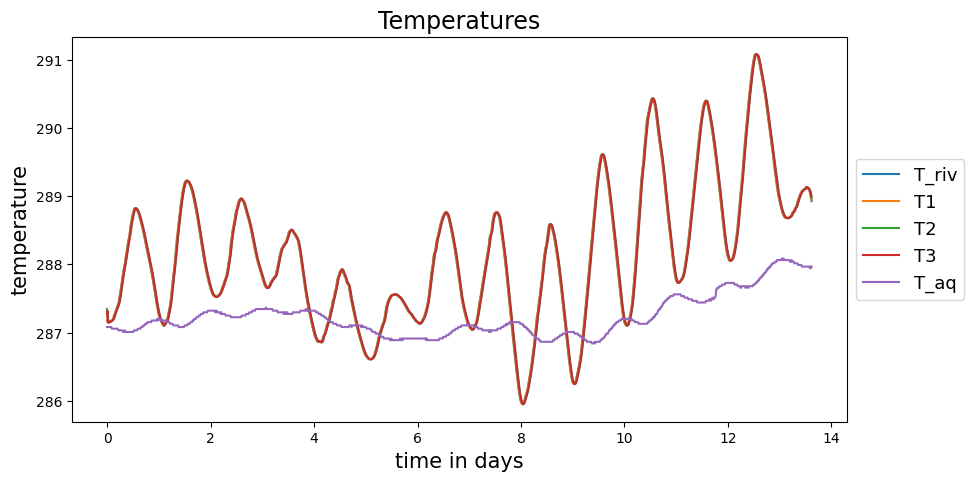

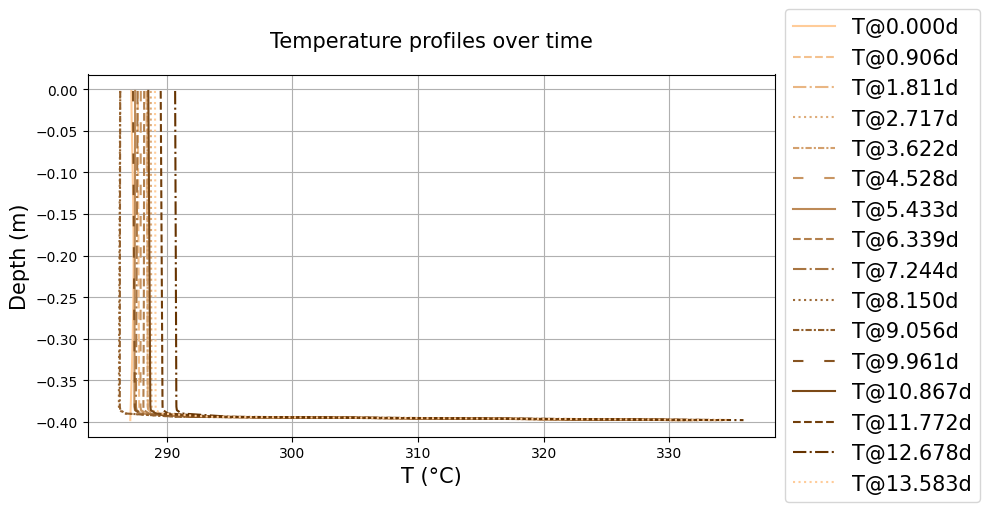

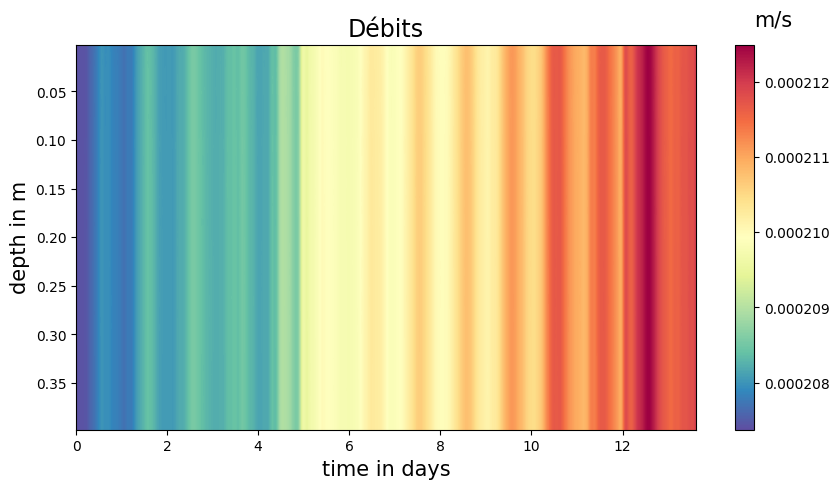

In [8]:
col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

Calcul des écarts de température et comparaison des températures simulées et observées

In [9]:
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

RMSE at sensor 0 : 0.522556000531669
RMSE at sensor 1 : 0.8845595849257549
RMSE at sensor 2 : 1.0700735153039194
Total RMSE : 0.8564593318094686


KeyboardInterrupt: 

<Figure size 2000x500 with 0 Axes>

The simulations are of very pour quality. Let's inverse the data with mcmc

### 2.2 Bayesian inversion

In [ ]:
priors = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1, 10), .1),
}

all_priors = [
    ['Couche 1', Zbottom, priors],
]
col.compute_mcmc(
    nb_iter = 500,
    all_priors = all_priors,
    sigma2=1.0,
    verbose=True
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, verbose=False)
col.plot_all_results()

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.01, 0.25), 0.01), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1, 10), 0.1)}
5
5
5
5
5
5
5
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1 et 10]
Number of cells : 100
Number of iterations : 500
Number of chains : 5
--------------------
[[ 8.4133732e-01 -5.0755695e+02 -3.5041959e+02 ... -3.9366873e+02
  -3.9367068e+02 -3.9367188e+02]
 [ 8.3288169e-01 -1.5046005e+03 -1.0461764e+03 ... -1.1707922e+03
  -1.1707981e+03 -1.1708015e+03]
 [ 8.2442605e-01 -2.4756694e+03 -1.7325413e+03 ... -1.9319935e+03
  -1.9320034e+03 -1.9320088e+03]
 ...
 [ 2.1139130e-02 -2.4772397e+03 -1.7336952e+03 ... -1.9333264e+03
  -1.9333138e+03 -1.9333190e+03]
 [ 1.2683477e-02 -1.5059189

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:40: RuntimeWarning: overflow encountered in exp
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))


[[ 8.41337323e-01 -1.26936211e+04 -1.64356387e+04 ... -3.39682000e+05
  -3.39704250e+05 -3.39726625e+05]
 [ 8.32881689e-01 -2.63504121e+04 -4.12920000e+04 ... -1.00852131e+06
  -1.00858819e+06 -1.00865500e+06]
 [ 8.24426055e-01 -3.27160840e+04 -5.67412891e+04 ... -1.66334275e+06
  -1.66345412e+06 -1.66356538e+06]
 ...
 [ 2.11391300e-02 -3.27265195e+04 -5.67687266e+04 ... -1.66379288e+06
  -1.66390462e+06 -1.66401575e+06]
 [ 1.26834773e-02 -2.63643926e+04 -4.13208984e+04 ... -1.00881212e+06
  -1.00887919e+06 -1.00894594e+06]
 [ 4.22782591e-03 -1.27052607e+04 -1.64517656e+04 ... -3.39786719e+05
  -3.39809094e+05 -3.39831344e+05]]
Initialisation - Utilisation de la mémoire (en Mo) : 264.6016
--- Begin Burn in phase ---


Burn in phase:   0%|          | 0/500 [00:00<?, ?it/s]

[[ 8.4133732e-01 -8.2634564e+02 -6.6907452e+02 ... -7.1958484e+02
  -7.1958667e+02 -7.1958752e+02]
 [ 8.3288169e-01 -2.4447490e+03 -1.9964840e+03 ... -2.1386748e+03
  -2.1386804e+03 -2.1386826e+03]
 [ 8.2442605e-01 -4.0161431e+03 -3.3065081e+03 ... -3.5286892e+03
  -3.5286985e+03 -3.5287024e+03]
 ...
 [ 2.1139130e-02 -4.0183191e+03 -3.3080178e+03 ... -3.5304385e+03
  -3.5304539e+03 -3.5304578e+03]
 [ 1.2683477e-02 -2.4464619e+03 -1.9977535e+03 ... -2.1401125e+03
  -2.1401218e+03 -2.1401240e+03]
 [ 4.2278259e-03 -8.2750507e+02 -6.7007007e+02 ... -7.2065527e+02
  -7.2065826e+02 -7.2065918e+02]]
[[ 8.4133732e-01 -6.5170957e+03 -8.5073174e+03 ... -1.8736700e+05
  -1.8738464e+05 -1.8740228e+05]
 [ 8.3288169e-01 -1.3192354e+04 -2.0989373e+04 ... -5.5620688e+05
  -5.5625981e+05 -5.5631269e+05]
 [ 8.2442605e-01 -1.6132436e+04 -2.8390479e+04 ... -9.1720119e+05
  -9.1728938e+05 -9.1737744e+05]
 ...
 [ 2.1139130e-02 -1.6137546e+04 -2.8403736e+04 ... -9.1745575e+05
  -9.1754388e+05 -9.1763194e+05]

Burn in phase:   0%|          | 1/500 [00:00<02:51,  2.91it/s]

[[ 8.4133732e-01 -2.9519846e+03 -5.0280156e+03 ... -1.7702017e+05
  -1.7708886e+05 -1.7715755e+05]
 [ 8.3288169e-01 -3.6209297e+03 -7.0763887e+03 ... -5.1555784e+05
  -5.1576378e+05 -5.1596969e+05]
 [ 8.2442605e-01 -3.6794255e+03 -7.3372959e+03 ... -8.3420919e+05
  -8.3455200e+05 -8.3489475e+05]
 ...
 [ 2.1139130e-02 -3.6802544e+03 -7.3382441e+03 ... -8.3468006e+05
  -8.3502306e+05 -8.3536588e+05]
 [ 1.2683477e-02 -3.6219470e+03 -7.0780479e+03 ... -5.1586972e+05
  -5.1607578e+05 -5.1628178e+05]
 [ 4.2278259e-03 -2.9539053e+03 -5.0318354e+03 ... -1.7713534e+05
  -1.7720406e+05 -1.7727275e+05]]
[[ 8.4133732e-01 -1.8240353e+03 -2.1790027e+03 ... -8.3361553e+03
  -8.3361553e+03 -8.3361553e+03]
 [ 8.3288169e-01 -5.0832998e+03 -6.3842817e+03 ... -2.4757832e+04
  -2.4757832e+04 -2.4757832e+04]
 [ 8.2442605e-01 -7.8936294e+03 -1.0356697e+04 ... -4.0843043e+04
  -4.0843047e+04 -4.0843047e+04]
 ...
 [ 2.1139130e-02 -7.8993911e+03 -1.0363849e+04 ... -4.0854582e+04
  -4.0854625e+04 -4.0854625e+04]

Burn in phase:   0%|          | 2/500 [00:00<02:24,  3.45it/s]

[[ 8.4133732e-01 -2.7115471e+03 -4.6185347e+03 ... -1.6260644e+05
  -1.6266955e+05 -1.6273264e+05]
 [ 8.3288169e-01 -3.3260232e+03 -6.5001172e+03 ... -4.7357909e+05
  -4.7376831e+05 -4.7395750e+05]
 [ 8.2442605e-01 -3.3797563e+03 -6.7397803e+03 ... -7.6628500e+05
  -7.6659988e+05 -7.6691469e+05]
 ...
 [ 2.1139130e-02 -3.3805833e+03 -6.7407168e+03 ... -7.6671725e+05
  -7.6703225e+05 -7.6734719e+05]
 [ 1.2683477e-02 -3.3270247e+03 -6.5017085e+03 ... -4.7386550e+05
  -4.7405484e+05 -4.7424406e+05]
 [ 4.2278259e-03 -2.7133792e+03 -4.6221113e+03 ... -1.6271225e+05
  -1.6277539e+05 -1.6283848e+05]]
[[ 8.41337323e-01 -2.52109277e+03 -3.00623364e+03 ... -1.05460049e+04
  -1.05460098e+04 -1.05460049e+04]
 [ 8.32881689e-01 -7.06793457e+03 -8.82639844e+03 ... -3.13204863e+04
  -3.13205000e+04 -3.13204863e+04]
 [ 8.24426055e-01 -1.10363770e+04 -1.43553398e+04 ... -5.16693203e+04
  -5.16693398e+04 -5.16693203e+04]
 ...
 [ 2.11391300e-02 -1.10440615e+04 -1.43646514e+04 ... -5.16840195e+04
  -5.16840

Burn in phase:   1%|          | 3/500 [00:00<02:14,  3.70it/s]

[[ 8.4133732e-01 -4.2287960e+01 -2.5104277e+01 ... -3.0214939e+01
  -3.0214930e+01 -3.0214979e+01]
 [ 8.3288169e-01 -1.2699547e+02 -7.6472885e+01 ... -9.1432625e+01
  -9.1432617e+01 -9.1432625e+01]
 [ 8.2442605e-01 -2.0964491e+02 -1.2711067e+02 ... -1.5139621e+02
  -1.5139621e+02 -1.5139616e+02]
 ...
 [ 2.1139130e-02 -2.1050882e+02 -1.2793968e+02 ... -1.5225586e+02
  -1.5225676e+02 -1.5225604e+02]
 [ 1.2683477e-02 -1.2785507e+02 -7.7309608e+01 ... -9.2295937e+01
  -9.2296478e+01 -9.2296036e+01]
 [ 4.2278259e-03 -4.3139297e+01 -2.5947309e+01 ... -3.1079506e+01
  -3.1079683e+01 -3.1079538e+01]]
[[ 8.4133732e-01 -1.0536849e+04 -1.6899080e+04 ... -5.4597444e+05
  -5.4618506e+05 -5.4639562e+05]
 [ 8.3288169e-01 -1.4081911e+04 -2.6927148e+04 ... -1.6008019e+06
  -1.6014336e+06 -1.6020652e+06]
 [ 8.2442605e-01 -1.4548805e+04 -2.8844883e+04 ... -2.6075818e+06
  -2.6086335e+06 -2.6096850e+06]
 ...
 [ 2.1139130e-02 -1.4549898e+04 -2.8847178e+04 ... -2.6088680e+06
  -2.6099198e+06 -2.6109715e+06]

Burn in phase:   1%|          | 4/500 [00:01<02:08,  3.86it/s]

[[ 8.4133732e-01 -9.6897327e+02 -1.4832883e+03 ... -4.5906832e+04
  -4.5924195e+04 -4.5941547e+04]
 [ 8.3288169e-01 -1.3937369e+03 -2.6043569e+03 ... -1.3512933e+05
  -1.3518139e+05 -1.3523344e+05]
 [ 8.2442605e-01 -1.4675513e+03 -2.8857510e+03 ... -2.2097672e+05
  -2.2106344e+05 -2.2115011e+05]
 ...
 [ 2.1139130e-02 -1.4684114e+03 -2.8868232e+03 ... -2.2107575e+05
  -2.2116248e+05 -2.2124917e+05]
 [ 1.2683477e-02 -1.3947745e+03 -2.6059414e+03 ... -1.3519408e+05
  -1.3524614e+05 -1.3529820e+05]
 [ 4.2278259e-03 -9.7037225e+02 -1.4853589e+03 ... -4.5930781e+04
  -4.5948137e+04 -4.5965492e+04]]
[[ 8.4133732e-01 -6.4836377e+02 -7.8185431e+02 ... -4.3486924e+03
  -4.3486929e+03 -4.3486953e+03]
 [ 8.3288169e-01 -1.7497172e+03 -2.2637942e+03 ... -1.2916142e+04
  -1.2916145e+04 -1.2916152e+04]
 [ 8.2442605e-01 -2.6389331e+03 -3.6182136e+03 ... -2.1308055e+04
  -2.1308055e+04 -2.1308072e+04]
 ...
 [ 2.1139130e-02 -2.6413667e+03 -3.6214241e+03 ... -2.1314486e+04
  -2.1314486e+04 -2.1314484e+04]

Burn in phase:   1%|          | 5/500 [00:01<02:05,  3.96it/s]

[[ 8.41337323e-01 -4.03060522e+03 -5.45296045e+03 ... -1.42973438e+05
  -1.43004297e+05 -1.43035094e+05]
 [ 8.32881689e-01 -7.39817285e+03 -1.24300928e+04 ... -4.23928719e+05
  -4.24021219e+05 -4.24113625e+05]
 [ 8.24426055e-01 -8.57607715e+03 -1.58162295e+04 ... -6.98271438e+05
  -6.98425562e+05 -6.98579375e+05]
 ...
 [ 2.11391300e-02 -8.57837988e+03 -1.58221143e+04 ... -6.98481375e+05
  -6.98635500e+05 -6.98789375e+05]
 [ 1.26834773e-02 -7.40175684e+03 -1.24379668e+04 ... -4.24064688e+05
  -4.24157219e+05 -4.24249594e+05]
 [ 4.22782591e-03 -4.03462915e+03 -5.45891211e+03 ... -1.43022766e+05
  -1.43053609e+05 -1.43084422e+05]]
[[ 8.4133732e-01 -1.5958615e+04 -2.3854023e+04 ... -7.2418231e+05
  -7.2444912e+05 -7.2471588e+05]
 [ 8.3288169e-01 -2.3877143e+04 -4.3970730e+04 ... -2.1352718e+06
  -2.1360720e+06 -2.1368720e+06]
 [ 8.2442605e-01 -2.5447969e+04 -4.9712598e+04 ... -3.4976990e+06
  -3.4990320e+06 -3.5003645e+06]
 ...
 [ 2.1139130e-02 -2.5450117e+04 -4.9719453e+04 ... -3.4991248e

Burn in phase:   1%|          | 6/500 [00:01<02:04,  3.97it/s]

[[ 8.4133732e-01 -9.5041634e+01 -7.0872627e+01 ... -7.7558884e+01
  -7.7559151e+01 -7.7559120e+01]
 [ 8.3288169e-01 -2.8289352e+02 -2.1295944e+02 ... -2.3203133e+02
  -2.3203214e+02 -2.3203194e+02]
 [ 8.2442605e-01 -4.6560367e+02 -3.5316663e+02 ... -3.8333896e+02
  -3.8334033e+02 -3.8333994e+02]
 ...
 [ 2.1139130e-02 -4.6655798e+02 -3.5404230e+02 ... -3.8426099e+02
  -3.8426193e+02 -3.8426151e+02]
 [ 1.2683477e-02 -2.8381186e+02 -2.1382585e+02 ... -2.3293488e+02
  -2.3293542e+02 -2.3293520e+02]
 [ 4.2278259e-03 -9.5914185e+01 -7.1726120e+01 ... -7.8437851e+01
  -7.8438034e+01 -7.8437958e+01]]
[[ 8.4133732e-01 -6.1955664e+03 -8.4798828e+03 ... -2.2972502e+05
  -2.2978188e+05 -2.2983869e+05]
 [ 8.3288169e-01 -1.1055660e+04 -1.8844381e+04 ... -6.8080969e+05
  -6.8098025e+05 -6.8115062e+05]
 [ 8.2442605e-01 -1.2640584e+04 -2.3566666e+04 ... -1.1208340e+06
  -1.1211180e+06 -1.1214018e+06]
 ...
 [ 2.1139130e-02 -1.2643318e+04 -2.3574293e+04 ... -1.1211824e+06
  -1.1214665e+06 -1.1217502e+06]

Burn in phase:   1%|▏         | 7/500 [00:01<02:02,  4.02it/s]

[[ 8.41337323e-01 -2.95181055e+03 -4.00374854e+03 ... -1.05812367e+05
  -1.05835984e+05 -1.05859570e+05]
 [ 8.32881689e-01 -5.38416406e+03 -9.07605078e+03 ... -3.13709969e+05
  -3.13780812e+05 -3.13851531e+05]
 [ 8.24426055e-01 -6.22184814e+03 -1.15037373e+04 ... -5.16671469e+05
  -5.16789406e+05 -5.16907156e+05]
 ...
 [ 2.11391300e-02 -6.22370654e+03 -1.15081533e+04 ... -5.16827250e+05
  -5.16945156e+05 -5.17062938e+05]
 [ 1.26834773e-02 -5.38696094e+03 -9.08196191e+03 ... -3.13811000e+05
  -3.13881750e+05 -3.13952469e+05]
 [ 4.22782591e-03 -2.95497021e+03 -4.00833984e+03 ... -1.05849188e+05
  -1.05872781e+05 -1.05896352e+05]]
[[ 8.4133732e-01 -1.0113516e+04 -1.6220158e+04 ... -5.2404084e+05
  -5.2424303e+05 -5.2444519e+05]
 [ 8.3288169e-01 -1.3516164e+04 -2.5845369e+04 ... -1.5364925e+06
  -1.5370990e+06 -1.5377051e+06]
 [ 8.2442605e-01 -1.3964301e+04 -2.7686062e+04 ... -2.5028268e+06
  -2.5038362e+06 -2.5048455e+06]
 ...
 [ 2.1139130e-02 -1.3965384e+04 -2.7688295e+04 ... -2.5040620e

Burn in phase:   2%|▏         | 8/500 [00:02<02:00,  4.08it/s]

[[ 8.4133732e-01 -9.6077332e+02 -1.1589766e+03 ... -6.5370713e+03
  -6.5370669e+03 -6.5370713e+03]
 [ 8.3288169e-01 -2.5882490e+03 -3.3529780e+03 ... -1.9415037e+04
  -1.9415025e+04 -1.9415035e+04]
 [ 8.2442605e-01 -3.8982986e+03 -5.3549688e+03 ... -3.2029146e+04
  -3.2029123e+04 -3.2029146e+04]
 ...
 [ 2.1139130e-02 -3.9015061e+03 -5.3593403e+03 ... -3.2038432e+04
  -3.2038443e+04 -3.2038432e+04]
 [ 1.2683477e-02 -2.5909392e+03 -3.3562341e+03 ... -1.9421340e+04
  -1.9421344e+04 -1.9421340e+04]
 [ 4.2278259e-03 -9.6242761e+02 -1.1607175e+03 ... -6.5398838e+03
  -6.5398862e+03 -6.5398838e+03]]
[[ 8.41337323e-01 -1.17389160e+03 -1.48219507e+03 ... -2.30672090e+04
  -2.30673652e+04 -2.30675234e+04]
 [ 8.32881689e-01 -2.65772778e+03 -3.93859351e+03 ... -6.85041016e+04
  -6.85045703e+04 -6.85050469e+04]
 [ 8.24426055e-01 -3.49237280e+03 -5.70979004e+03 ... -1.13008773e+05
  -1.13009578e+05 -1.13010352e+05]
 ...
 [ 2.11391300e-02 -3.49456958e+03 -5.71385938e+03 ... -1.13039516e+05
  -1.13040

Burn in phase:   2%|▏         | 9/500 [00:02<02:00,  4.07it/s]

[[ 8.4133732e-01 -8.2860803e+02 -9.6437939e+02 ... -1.6525796e+03
  -1.6525793e+03 -1.6525789e+03]
 [ 8.3288169e-01 -2.4067893e+03 -2.8656707e+03 ... -4.9094175e+03
  -4.9094165e+03 -4.9094150e+03]
 [ 8.2442605e-01 -3.8841680e+03 -4.7249336e+03 ... -8.0995264e+03
  -8.0995234e+03 -8.0995229e+03]
 ...
 [ 2.1139130e-02 -3.8870105e+03 -4.7275679e+03 ... -8.1024438e+03
  -8.1024507e+03 -8.1024561e+03]
 [ 1.2683477e-02 -2.4089780e+03 -2.8676533e+03 ... -4.9116113e+03
  -4.9116147e+03 -4.9116187e+03]
 [ 4.2278259e-03 -8.2995624e+02 -9.6562463e+02 ... -1.6539215e+03
  -1.6539227e+03 -1.6539238e+03]]
[[ 8.4133732e-01 -1.0324107e+04 -1.6557895e+04 ... -5.3494938e+05
  -5.3515581e+05 -5.3536212e+05]
 [ 8.3288169e-01 -1.3797601e+04 -2.6383508e+04 ... -1.5684762e+06
  -1.5690954e+06 -1.5697141e+06]
 [ 8.2442605e-01 -1.4255066e+04 -2.8262527e+04 ... -2.5549252e+06
  -2.5559558e+06 -2.5569862e+06]
 ...
 [ 2.1139130e-02 -1.4256155e+04 -2.8264793e+04 ... -2.5561855e+06
  -2.5572165e+06 -2.5582470e+06]

Burn in phase:   2%|▏         | 10/500 [00:02<01:59,  4.10it/s]

[[ 8.4133732e-01 -9.6897327e+02 -1.4832883e+03 ... -4.5906832e+04
  -4.5924195e+04 -4.5941547e+04]
 [ 8.3288169e-01 -1.3937369e+03 -2.6043569e+03 ... -1.3512933e+05
  -1.3518139e+05 -1.3523344e+05]
 [ 8.2442605e-01 -1.4675513e+03 -2.8857510e+03 ... -2.2097672e+05
  -2.2106344e+05 -2.2115011e+05]
 ...
 [ 2.1139130e-02 -1.4684114e+03 -2.8868232e+03 ... -2.2107575e+05
  -2.2116248e+05 -2.2124917e+05]
 [ 1.2683477e-02 -1.3947745e+03 -2.6059414e+03 ... -1.3519408e+05
  -1.3524614e+05 -1.3529820e+05]
 [ 4.2278259e-03 -9.7037225e+02 -1.4853589e+03 ... -4.5930781e+04
  -4.5948137e+04 -4.5965492e+04]]
[[ 8.4133732e-01 -5.7269810e+03 -8.7939609e+03 ... -2.7278591e+05
  -2.7288931e+05 -2.7299266e+05]
 [ 8.3288169e-01 -8.1907520e+03 -1.5330654e+04 ... -8.0274769e+05
  -8.0305788e+05 -8.0336788e+05]
 [ 8.2442605e-01 -8.6107725e+03 -1.6941111e+04 ... -1.3123961e+06
  -1.3129126e+06 -1.3134289e+06]
 ...
 [ 2.1139130e-02 -8.6118945e+03 -1.6943434e+04 ... -1.3129988e+06
  -1.3135151e+06 -1.3140315e+06]

Burn in phase:   2%|▏         | 11/500 [00:02<01:58,  4.13it/s]

[[ 8.41337323e-01 -4.38091087e+01 -2.41642456e+01 ... -3.03040428e+01
  -3.03039951e+01 -3.03043671e+01]
 [ 8.32881689e-01 -1.31553085e+02 -7.36524429e+01 ... -9.16972504e+01
  -9.16971130e+01 -9.16980972e+01]
 [ 8.24426055e-01 -2.17227737e+02 -1.22412300e+02 ... -1.51832764e+02
  -1.51832535e+02 -1.51834137e+02]
 ...
 [ 2.11391300e-02 -2.18093750e+02 -1.23240326e+02 ... -1.52693268e+02
  -1.52692474e+02 -1.52694672e+02]
 [ 1.26834773e-02 -1.32413956e+02 -7.44885788e+01 ... -9.25610886e+01
  -9.25606003e+01 -9.25619278e+01]
 [ 4.22782591e-03 -4.46608734e+01 -2.50070839e+01 ... -3.11687870e+01
  -3.11686268e+01 -3.11690693e+01]]
[[ 8.4133732e-01 -4.8002749e+03 -7.5950220e+03 ... -2.4197361e+05
  -2.4206666e+05 -2.4215966e+05]
 [ 8.3288169e-01 -6.5488086e+03 -1.2446548e+04 ... -7.1033781e+05
  -7.1061688e+05 -7.1089581e+05]
 [ 8.2442605e-01 -6.7990176e+03 -1.3453368e+04 ... -1.1584966e+06
  -1.1589614e+06 -1.1594260e+06]
 ...
 [ 2.1139130e-02 -6.7999863e+03 -1.3455006e+04 ... -1.1590548e

Burn in phase:   2%|▏         | 12/500 [00:03<01:58,  4.13it/s]

[[ 8.4133732e-01 -4.3813145e+03 -5.2264736e+03 ... -1.8712129e+04
  -1.8712131e+04 -1.8712131e+04]
 [ 8.3288169e-01 -1.2264996e+04 -1.5336365e+04 ... -5.5571664e+04
  -5.5571676e+04 -5.5571676e+04]
 [ 8.2442605e-01 -1.9126725e+04 -2.4928150e+04 ... -9.1676000e+04
  -9.1676008e+04 -9.1676023e+04]
 ...
 [ 2.1139130e-02 -1.9139490e+04 -2.4943875e+04 ... -9.1700812e+04
  -9.1700883e+04 -9.1700859e+04]
 [ 1.2683477e-02 -1.2274423e+04 -1.5346936e+04 ... -5.5588008e+04
  -5.5588051e+04 -5.5588043e+04]
 [ 4.2278259e-03 -4.3856094e+03 -5.2308096e+03 ... -1.8718541e+04
  -1.8718555e+04 -1.8718553e+04]]
[[ 8.4133732e-01 -5.8300537e+03 -8.9522246e+03 ... -2.7769809e+05
  -2.7780338e+05 -2.7790859e+05]
 [ 8.3288169e-01 -8.3381592e+03 -1.5606544e+04 ... -8.1720338e+05
  -8.1751912e+05 -8.1783475e+05]
 [ 8.2442605e-01 -8.7657373e+03 -1.7245979e+04 ... -1.3360298e+06
  -1.3365556e+06 -1.3370812e+06]
 ...
 [ 2.1139130e-02 -8.7668662e+03 -1.7248334e+04 ... -1.3366439e+06
  -1.3371698e+06 -1.3376956e+06]

Burn in phase:   3%|▎         | 13/500 [00:03<01:58,  4.09it/s]

[[ 8.4133732e-01 -5.9232432e+03 -8.9132246e+03 ... -2.7204309e+05
  -2.7214428e+05 -2.7224538e+05]
 [ 8.3288169e-01 -8.7615244e+03 -1.6204087e+04 ... -8.0175412e+05
  -8.0205756e+05 -8.0236069e+05]
 [ 8.2442605e-01 -9.3039805e+03 -1.8211461e+04 ... -1.3127126e+06
  -1.3132180e+06 -1.3137229e+06]
 ...
 [ 2.1139130e-02 -9.3052354e+03 -1.8214326e+04 ... -1.3132790e+06
  -1.3137844e+06 -1.3142895e+06]
 [ 1.2683477e-02 -8.7639033e+03 -1.6210196e+04 ... -8.0212169e+05
  -8.0242512e+05 -8.0272844e+05]
 [ 4.2278259e-03 -5.9276968e+03 -8.9216973e+03 ... -2.7217609e+05
  -2.7227725e+05 -2.7237838e+05]]
[[ 8.4133732e-01 -1.9674696e+02 -2.3413391e+02 ... -7.1897229e+02
  -7.1897144e+02 -7.1897180e+02]
 [ 8.3288169e-01 -5.5771674e+02 -6.9098462e+02 ... -2.1368557e+03
  -2.1368530e+03 -2.1368542e+03]
 [ 8.2442605e-01 -8.7818536e+02 -1.1283066e+03 ... -3.5256880e+03
  -3.5256836e+03 -3.5256855e+03]
 ...
 [ 2.1139130e-02 -8.7953027e+02 -1.1297463e+03 ... -3.5274482e+03
  -3.5274424e+03 -3.5274443e+03]

Burn in phase:   3%|▎         | 14/500 [00:03<01:57,  4.12it/s]

[[ 8.4133732e-01 -1.2675914e+04 -1.8439826e+04 ... -5.4711912e+05
  -5.4730994e+05 -5.4750062e+05]
 [ 8.3288169e-01 -1.9915619e+04 -3.5976332e+04 ... -1.6160700e+06
  -1.6166424e+06 -1.6172141e+06]
 [ 8.2442605e-01 -2.1585352e+04 -4.1760637e+04 ... -2.6518915e+06
  -2.6528445e+06 -2.6537970e+06]
 ...
 [ 2.1139130e-02 -2.1587752e+04 -4.1768188e+04 ... -2.6529310e+06
  -2.6538845e+06 -2.6548370e+06]
 [ 1.2683477e-02 -1.9920979e+04 -3.5991422e+04 ... -1.6167422e+06
  -1.6173145e+06 -1.6178866e+06]
 [ 4.2278259e-03 -1.2685257e+04 -1.8457207e+04 ... -5.4736119e+05
  -5.4755194e+05 -5.4774269e+05]]
[[ 8.4133732e-01 -3.5574919e+03 -4.2066548e+03 ... -9.8403984e+03
  -9.8403955e+03 -9.8403896e+03]
 [ 8.3288169e-01 -1.0199754e+04 -1.2445470e+04 ... -2.9225033e+04
  -2.9225023e+04 -2.9225004e+04]
 [ 8.2442605e-01 -1.6264449e+04 -2.0425959e+04 ... -4.8212504e+04
  -4.8212484e+04 -4.8212449e+04]
 ...
 [ 2.1139130e-02 -1.6274741e+04 -2.0436717e+04 ... -4.8225742e+04
  -4.8225707e+04 -4.8225676e+04]

Burn in phase:   3%|▎         | 15/500 [00:03<01:58,  4.08it/s]

[[ 8.4133732e-01 -9.6897327e+02 -1.4832883e+03 ... -4.5906832e+04
  -4.5924195e+04 -4.5941547e+04]
 [ 8.3288169e-01 -1.3937369e+03 -2.6043569e+03 ... -1.3512933e+05
  -1.3518139e+05 -1.3523344e+05]
 [ 8.2442605e-01 -1.4675513e+03 -2.8857510e+03 ... -2.2097672e+05
  -2.2106344e+05 -2.2115011e+05]
 ...
 [ 2.1139130e-02 -1.4684114e+03 -2.8868232e+03 ... -2.2107575e+05
  -2.2116248e+05 -2.2124917e+05]
 [ 1.2683477e-02 -1.3947745e+03 -2.6059414e+03 ... -1.3519408e+05
  -1.3524614e+05 -1.3529820e+05]
 [ 4.2278259e-03 -9.7037225e+02 -1.4853589e+03 ... -4.5930781e+04
  -4.5948137e+04 -4.5965492e+04]]
[[ 8.4133732e-01 -5.7269810e+03 -8.7939609e+03 ... -2.7278591e+05
  -2.7288931e+05 -2.7299266e+05]
 [ 8.3288169e-01 -8.1907520e+03 -1.5330654e+04 ... -8.0274769e+05
  -8.0305788e+05 -8.0336788e+05]
 [ 8.2442605e-01 -8.6107725e+03 -1.6941111e+04 ... -1.3123961e+06
  -1.3129126e+06 -1.3134289e+06]
 ...
 [ 2.1139130e-02 -8.6118945e+03 -1.6943434e+04 ... -1.3129988e+06
  -1.3135151e+06 -1.3140315e+06]

Burn in phase:   3%|▎         | 16/500 [00:04<01:57,  4.11it/s]

[[ 8.4133732e-01 -3.0750977e+03 -4.7063389e+03 ... -1.4560222e+05
  -1.4565730e+05 -1.4571233e+05]
 [ 8.3288169e-01 -4.4222925e+03 -8.2619873e+03 ... -4.2858456e+05
  -4.2874972e+05 -4.2891475e+05]
 [ 8.2442605e-01 -4.6563892e+03 -9.1544609e+03 ... -7.0086219e+05
  -7.0113719e+05 -7.0141206e+05]
 ...
 [ 2.1139130e-02 -4.6573730e+03 -9.1561162e+03 ... -7.0117475e+05
  -7.0144988e+05 -7.0172488e+05]
 [ 1.2683477e-02 -4.4238022e+03 -8.2652324e+03 ... -4.2878828e+05
  -4.2895344e+05 -4.2911853e+05]
 [ 4.2278259e-03 -3.0777168e+03 -4.7110884e+03 ... -1.4567638e+05
  -1.4573145e+05 -1.4578648e+05]]
[[ 8.4133732e-01 -1.6652240e+03 -1.9768344e+03 ... -5.5063623e+03
  -5.5063569e+03 -5.5063516e+03]
 [ 8.3288169e-01 -4.7341763e+03 -5.8325527e+03 ... -1.6354113e+04
  -1.6354095e+04 -1.6354079e+04]
 [ 8.2442605e-01 -7.4882227e+03 -9.5406562e+03 ... -2.6979607e+04
  -2.6979572e+04 -2.6979549e+04]
 ...
 [ 2.1139130e-02 -7.4935620e+03 -9.5465850e+03 ... -2.6987336e+04
  -2.6987367e+04 -2.6987320e+04]

Burn in phase:   3%|▎         | 17/500 [00:04<01:57,  4.11it/s]

[[ 8.4133732e-01 -5.8686812e+03 -6.8267271e+03 ... -1.1645955e+04
  -1.1645956e+04 -1.1645954e+04]
 [ 8.3288169e-01 -1.7039008e+04 -2.0276510e+04 ... -3.4587039e+04
  -3.4587043e+04 -3.4587031e+04]
 [ 8.2442605e-01 -2.7498947e+04 -3.3430348e+04 ... -5.7058078e+04
  -5.7058086e+04 -5.7058062e+04]
 ...
 [ 2.1139130e-02 -2.7514254e+04 -3.3444184e+04 ... -5.7073871e+04
  -5.7073746e+04 -5.7073766e+04]
 [ 1.2683477e-02 -1.7049553e+04 -2.0285594e+04 ... -3.4597543e+04
  -3.4597473e+04 -3.4597477e+04]
 [ 4.2278259e-03 -5.8731479e+03 -6.8304629e+03 ... -1.1650276e+04
  -1.1650251e+04 -1.1650254e+04]]
[[ 8.4133732e-01 -5.7269810e+03 -8.7939609e+03 ... -2.7278591e+05
  -2.7288931e+05 -2.7299266e+05]
 [ 8.3288169e-01 -8.1907520e+03 -1.5330654e+04 ... -8.0274769e+05
  -8.0305788e+05 -8.0336788e+05]
 [ 8.2442605e-01 -8.6107725e+03 -1.6941111e+04 ... -1.3123961e+06
  -1.3129126e+06 -1.3134289e+06]
 ...
 [ 2.1139130e-02 -8.6118945e+03 -1.6943434e+04 ... -1.3129988e+06
  -1.3135151e+06 -1.3140315e+06]

Burn in phase:   4%|▎         | 18/500 [00:04<02:02,  3.93it/s]

[[ 8.4133732e-01 -1.1241830e+04 -1.3298791e+04 ... -3.1641818e+04
  -3.1641809e+04 -3.1641746e+04]
 [ 8.3288169e-01 -3.2203000e+04 -3.9331027e+04 ... -9.3969367e+04
  -9.3969328e+04 -9.3969148e+04]
 [ 8.2442605e-01 -5.1311496e+04 -6.4531035e+04 ... -1.5501991e+05
  -1.5501981e+05 -1.5501955e+05]
 ...
 [ 2.1139130e-02 -5.1342332e+04 -6.4563496e+04 ... -1.5505989e+05
  -1.5506011e+05 -1.5506039e+05]
 [ 1.2683477e-02 -3.2224479e+04 -3.9352113e+04 ... -9.3995578e+04
  -9.3995695e+04 -9.3995883e+04]
 [ 4.2278259e-03 -1.1250586e+04 -1.3306788e+04 ... -3.1651793e+04
  -3.1651830e+04 -3.1651895e+04]]
[[ 8.4133732e-01 -1.2492825e+03 -2.1980056e+03 ... -8.3112234e+04
  -8.3144562e+04 -8.3176891e+04]
 [ 8.3288169e-01 -1.4674268e+03 -2.8927273e+03 ... -2.4083639e+05
  -2.4093331e+05 -2.4103022e+05]
 [ 8.2442605e-01 -1.4820277e+03 -2.9604805e+03 ... -3.8772975e+05
  -3.8789097e+05 -3.8805219e+05]
 ...
 [ 2.1139130e-02 -1.4828362e+03 -2.9613140e+03 ... -3.8796059e+05
  -3.8812188e+05 -3.8828312e+05]

Burn in phase:   4%|▍         | 19/500 [00:04<02:00,  3.98it/s]

[[ 8.4133732e-01 -6.1543335e+03 -1.0472867e+04 ... -3.6809859e+05
  -3.6824144e+05 -3.6838422e+05]
 [ 8.3288169e-01 -7.5575933e+03 -1.4765213e+04 ... -1.0721816e+06
  -1.0726100e+06 -1.0730381e+06]
 [ 8.2442605e-01 -7.6810942e+03 -1.5315489e+04 ... -1.7350652e+06
  -1.7357781e+06 -1.7364909e+06]
 ...
 [ 2.1139130e-02 -7.6819517e+03 -1.5316600e+04 ... -1.7360239e+06
  -1.7367370e+06 -1.7374499e+06]
 [ 1.2683477e-02 -7.5588296e+03 -1.4767801e+04 ... -1.0728172e+06
  -1.0732458e+06 -1.0736740e+06]
 [ 4.2278259e-03 -6.1574399e+03 -1.0479941e+04 ... -3.6833306e+05
  -3.6847594e+05 -3.6861878e+05]]
[[ 8.4133732e-01 -6.3717603e+03 -9.9042109e+03 ... -3.1041919e+05
  -3.1053775e+05 -3.1065625e+05]
 [ 8.3288169e-01 -8.9359150e+03 -1.6835469e+04 ... -9.1261888e+05
  -9.1297444e+05 -9.1332975e+05]
 [ 8.2442605e-01 -9.3433330e+03 -1.8429586e+04 ... -1.4905996e+06
  -1.4911916e+06 -1.4917834e+06]
 ...
 [ 2.1139130e-02 -9.3444297e+03 -1.8431816e+04 ... -1.4912909e+06
  -1.4918830e+06 -1.4924750e+06]

Burn in phase:   4%|▍         | 20/500 [00:05<01:58,  4.05it/s]

[[ 8.4133732e-01 -1.4458758e+04 -1.7800463e+04 ... -1.7673931e+05
  -1.7673930e+05 -1.7673927e+05]
 [ 8.3288169e-01 -3.6009289e+04 -4.9756566e+04 ... -5.2486962e+05
  -5.2486950e+05 -5.2486950e+05]
 [ 8.2442605e-01 -5.0811637e+04 -7.6285508e+04 ... -8.6586694e+05
  -8.6586688e+05 -8.6586675e+05]
 ...
 [ 2.1139130e-02 -5.0839176e+04 -7.6336641e+04 ... -8.6609381e+05
  -8.6609381e+05 -8.6609381e+05]
 [ 1.2683477e-02 -3.6034562e+04 -4.9795660e+04 ... -5.2501650e+05
  -5.2501638e+05 -5.2501644e+05]
 [ 4.2278259e-03 -1.4472358e+04 -1.7816773e+04 ... -1.7679253e+05
  -1.7679247e+05 -1.7679252e+05]]
[[ 8.4133732e-01 -1.0042156e+02 -1.1999154e+02 ... -4.3874115e+02
  -4.3874127e+02 -4.3874139e+02]
 [ 8.3288169e-01 -2.8229135e+02 -3.5355679e+02 ... -1.3046450e+03
  -1.3046455e+03 -1.3046456e+03]
 [ 8.2442605e-01 -4.4023404e+02 -5.7492474e+02 ... -2.1528079e+03
  -2.1528081e+03 -2.1528088e+03]
 ...
 [ 2.1139130e-02 -4.4131342e+02 -5.7607477e+02 ... -2.1541946e+03
  -2.1541951e+03 -2.1541948e+03]

Burn in phase:   4%|▍         | 21/500 [00:05<01:58,  4.05it/s]

[[ 8.4133732e-01 -1.1494498e+04 -1.9345127e+04 ... -6.6690719e+05
  -6.6716581e+05 -6.6742438e+05]
 [ 8.3288169e-01 -1.4331874e+04 -2.7904170e+04 ... -1.9453179e+06
  -1.9460932e+06 -1.9468685e+06]
 [ 8.2442605e-01 -1.4602885e+04 -2.9094584e+04 ... -3.1525162e+06
  -3.1538070e+06 -3.1550975e+06]
 ...
 [ 2.1139130e-02 -1.4603816e+04 -2.9096096e+04 ... -3.1542372e+06
  -3.1555285e+06 -3.1568190e+06]
 [ 1.2683477e-02 -1.4333596e+04 -2.7908754e+04 ... -1.9464546e+06
  -1.9472304e+06 -1.9480060e+06]
 [ 4.2278259e-03 -1.1499840e+04 -1.9358072e+04 ... -6.6732469e+05
  -6.6758338e+05 -6.6784206e+05]]
[[ 8.4133732e-01 -9.6897327e+02 -1.4832883e+03 ... -4.5906832e+04
  -4.5924195e+04 -4.5941547e+04]
 [ 8.3288169e-01 -1.3937369e+03 -2.6043569e+03 ... -1.3512933e+05
  -1.3518139e+05 -1.3523344e+05]
 [ 8.2442605e-01 -1.4675513e+03 -2.8857510e+03 ... -2.2097672e+05
  -2.2106344e+05 -2.2115011e+05]
 ...
 [ 2.1139130e-02 -1.4684114e+03 -2.8868232e+03 ... -2.2107575e+05
  -2.2116248e+05 -2.2124917e+05]

Burn in phase:   4%|▍         | 22/500 [00:05<01:58,  4.02it/s]

[[ 8.4133732e-01 -6.5418933e+02 -6.2400885e+02 ... -6.8379163e+02
  -6.8379230e+02 -6.8379272e+02]
 [ 8.3288169e-01 -1.9302245e+03 -1.8618434e+03 ... -2.0323788e+03
  -2.0323806e+03 -2.0323821e+03]
 [ 8.2442605e-01 -3.1621982e+03 -3.0829299e+03 ... -3.3533345e+03
  -3.3533379e+03 -3.3533406e+03]
 ...
 [ 2.1139130e-02 -3.1642017e+03 -3.0844370e+03 ... -3.3550198e+03
  -3.3550264e+03 -3.3550437e+03]
 [ 1.2683477e-02 -1.9318287e+03 -1.8631106e+03 ... -2.0337756e+03
  -2.0337794e+03 -2.0337899e+03]
 [ 4.2278259e-03 -6.5531104e+02 -6.2500330e+02 ... -6.8484753e+02
  -6.8484888e+02 -6.8485236e+02]]
[[ 8.4133732e-01 -1.3599583e+03 -1.9646263e+03 ... -5.7914863e+04
  -5.7934637e+04 -5.7954398e+04]
 [ 8.3288169e-01 -2.1661675e+03 -3.8917146e+03 ... -1.7114416e+05
  -1.7120347e+05 -1.7126273e+05]
 [ 8.2442605e-01 -2.3596199e+03 -4.5517407e+03 ... -2.8096125e+05
  -2.8106003e+05 -2.8115875e+05]
 ...
 [ 2.1139130e-02 -2.3606135e+03 -4.5533340e+03 ... -2.8106694e+05
  -2.8116578e+05 -2.8126450e+05]

Burn in phase:   5%|▍         | 23/500 [00:05<01:57,  4.04it/s]

[[ 8.4133732e-01 -1.0347570e+03 -1.2536093e+03 ... -8.1468145e+03
  -8.1468145e+03 -8.1468159e+03]
 [ 8.3288169e-01 -2.7433711e+03 -3.6034348e+03 ... -2.4195539e+04
  -2.4195541e+04 -2.4195545e+04]
 [ 8.2442605e-01 -4.0751636e+03 -5.7100981e+03 ... -3.9915438e+04
  -3.9915445e+04 -3.9915449e+04]
 ...
 [ 2.1139130e-02 -4.0784216e+03 -5.7147563e+03 ... -3.9926738e+04
  -3.9926730e+04 -3.9926738e+04]
 [ 1.2683477e-02 -2.7461641e+03 -3.6069402e+03 ... -2.4203143e+04
  -2.4203139e+04 -2.4203143e+04]
 [ 4.2278259e-03 -1.0364872e+03 -1.2554584e+03 ... -8.1500942e+03
  -8.1500933e+03 -8.1500942e+03]]
[[ 8.41337323e-01 -2.01683264e+03 -2.42365503e+03 ... -1.19259326e+04
  -1.19259346e+04 -1.19259375e+04]
 [ 8.32881689e-01 -5.50518066e+03 -7.04664795e+03 ... -3.54185000e+04
  -3.54185078e+04 -3.54185117e+04]
 [ 8.24426055e-01 -8.39031934e+03 -1.13252695e+04 ... -5.84297305e+04
  -5.84297383e+04 -5.84297539e+04]
 ...
 [ 2.11391300e-02 -8.39636230e+03 -1.13334482e+04 ... -5.84459023e+04
  -5.84459

Burn in phase:   5%|▍         | 24/500 [00:05<01:56,  4.07it/s]

[[ 8.4133732e-01 -1.3367906e+04 -1.7750996e+04 ... -4.3244822e+05
  -4.3251553e+05 -4.3258266e+05]
 [ 8.3288169e-01 -2.5758045e+04 -4.2157445e+04 ... -1.2831292e+06
  -1.2833312e+06 -1.2835326e+06]
 [ 8.2442605e-01 -3.0628598e+04 -5.5287934e+04 ... -2.1149312e+06
  -2.1152675e+06 -2.1156032e+06]
 ...
 [ 2.1139130e-02 -3.0636072e+04 -5.5309680e+04 ... -2.1155258e+06
  -2.1158622e+06 -2.1161982e+06]
 [ 1.2683477e-02 -2.5769750e+04 -4.2184195e+04 ... -1.2835140e+06
  -1.2837159e+06 -1.2839175e+06]
 [ 4.2278259e-03 -1.3379675e+04 -1.7768480e+04 ... -4.3258681e+05
  -4.3265406e+05 -4.3272131e+05]]
[[ 8.4133732e-01 -1.2624158e+04 -2.0198971e+04 ... -6.5092419e+05
  -6.5117525e+05 -6.5142612e+05]
 [ 8.3288169e-01 -1.6931094e+04 -3.2341963e+04 ... -1.9089309e+06
  -1.9096838e+06 -1.9104361e+06]
 [ 8.2442605e-01 -1.7506650e+04 -3.4697762e+04 ... -3.1101755e+06
  -3.1114288e+06 -3.1126820e+06]
 ...
 [ 2.1139130e-02 -1.7507811e+04 -3.4700414e+04 ... -3.1116862e+06
  -3.1129405e+06 -3.1141938e+06]

Burn in phase:   5%|▌         | 25/500 [00:06<01:58,  4.02it/s]

[[ 8.41337323e-01 -2.77697339e+03 -4.04092041e+03 ... -1.19939773e+05
  -1.19981633e+05 -1.20023438e+05]
 [ 8.32881689e-01 -4.36153369e+03 -7.88074658e+03 ... -3.54272094e+05
  -3.54397594e+05 -3.54523000e+05]
 [ 8.24426055e-01 -4.72653467e+03 -9.14577148e+03 ... -5.81335312e+05
  -5.81544375e+05 -5.81753312e+05]
 ...
 [ 2.11391300e-02 -4.72768604e+03 -9.14804785e+03 ... -5.81555625e+05
  -5.81764688e+05 -5.81973688e+05]
 [ 1.26834773e-02 -4.36334668e+03 -7.88468848e+03 ... -3.54415188e+05
  -3.54540750e+05 -3.54666188e+05]
 [ 4.22782591e-03 -2.77967358e+03 -4.04538257e+03 ... -1.19991875e+05
  -1.20033734e+05 -1.20075570e+05]]
[[ 8.4133732e-01 -6.5742383e+03 -1.0339356e+04 ... -3.2750753e+05
  -3.2763322e+05 -3.2775891e+05]
 [ 8.3288169e-01 -9.0521523e+03 -1.7154951e+04 ... -9.6192669e+05
  -9.6230369e+05 -9.6268056e+05]
 [ 8.2442605e-01 -9.4196777e+03 -1.8620125e+04 ... -1.5696216e+06
  -1.5702494e+06 -1.5708769e+06]
 ...
 [ 2.1139130e-02 -9.4207314e+03 -1.8622176e+04 ... -1.5703605e

Burn in phase:   5%|▌         | 26/500 [00:06<01:58,  4.00it/s]

[[ 8.4133732e-01 -1.9663507e+03 -2.8614524e+03 ... -8.4939125e+04
  -8.4968766e+04 -8.4998383e+04]
 [ 8.3288169e-01 -3.0885068e+03 -5.5807417e+03 ... -2.5088945e+05
  -2.5097833e+05 -2.5106716e+05]
 [ 8.2442605e-01 -3.3469956e+03 -6.4766099e+03 ... -4.1169191e+05
  -4.1183997e+05 -4.1198797e+05]
 ...
 [ 2.1139130e-02 -3.3480454e+03 -6.4784561e+03 ... -4.1184831e+05
  -4.1199641e+05 -4.1214438e+05]
 [ 1.2683477e-02 -3.0900300e+03 -5.5837729e+03 ... -2.5099109e+05
  -2.5108002e+05 -2.5116886e+05]
 [ 4.2278259e-03 -1.9685072e+03 -2.8648567e+03 ... -8.4976297e+04
  -8.5005938e+04 -8.5035562e+04]]
[[ 8.4133732e-01 -5.4282207e+03 -8.2875605e+03 ... -2.5588264e+05
  -2.5597922e+05 -2.5607577e+05]
 [ 8.3288169e-01 -7.8367222e+03 -1.4620494e+04 ... -7.5333238e+05
  -7.5362206e+05 -7.5391162e+05]
 [ 8.2442605e-01 -8.2609541e+03 -1.6231222e+04 ... -1.2321404e+06
  -1.2326229e+06 -1.2331051e+06]
 ...
 [ 2.1139130e-02 -8.2620869e+03 -1.6233580e+04 ... -1.2326834e+06
  -1.2331658e+06 -1.2336479e+06]

Burn in phase:   5%|▌         | 27/500 [00:06<01:57,  4.03it/s]

[[ 8.4133732e-01 -1.9663507e+03 -2.8614524e+03 ... -8.4939125e+04
  -8.4968766e+04 -8.4998383e+04]
 [ 8.3288169e-01 -3.0885068e+03 -5.5807417e+03 ... -2.5088945e+05
  -2.5097833e+05 -2.5106716e+05]
 [ 8.2442605e-01 -3.3469956e+03 -6.4766099e+03 ... -4.1169191e+05
  -4.1183997e+05 -4.1198797e+05]
 ...
 [ 2.1139130e-02 -3.3480454e+03 -6.4784561e+03 ... -4.1184831e+05
  -4.1199641e+05 -4.1214438e+05]
 [ 1.2683477e-02 -3.0900300e+03 -5.5837729e+03 ... -2.5099109e+05
  -2.5108002e+05 -2.5116886e+05]
 [ 4.2278259e-03 -1.9685072e+03 -2.8648567e+03 ... -8.4976297e+04
  -8.5005938e+04 -8.5035562e+04]]
[[ 8.4133732e-01 -5.4272842e+03 -8.2863779e+03 ... -2.5585377e+05
  -2.5595030e+05 -2.5604681e+05]
 [ 8.3288169e-01 -7.8349873e+03 -1.4617507e+04 ... -7.5324569e+05
  -7.5353525e+05 -7.5382475e+05]
 [ 8.2442605e-01 -8.2590059e+03 -1.6227510e+04 ... -1.2319958e+06
  -1.2324781e+06 -1.2329601e+06]
 ...
 [ 2.1139130e-02 -8.2601406e+03 -1.6229873e+04 ... -1.2325452e+06
  -1.2330278e+06 -1.2335100e+06]

Burn in phase:   6%|▌         | 28/500 [00:06<01:56,  4.06it/s]

[[ 8.4133732e-01 -1.0800804e+04 -1.5196897e+04 ... -4.3396831e+05
  -4.3410081e+05 -4.3423325e+05]
 [ 8.3288169e-01 -1.8126717e+04 -3.1818834e+04 ... -1.2843316e+06
  -1.2847290e+06 -1.2851264e+06]
 [ 8.2442605e-01 -2.0162604e+04 -3.8355422e+04 ... -2.1115615e+06
  -2.1122238e+06 -2.1128855e+06]
 ...
 [ 2.1139130e-02 -2.0165629e+04 -3.8364812e+04 ... -2.1122852e+06
  -2.1129478e+06 -2.1136092e+06]
 [ 1.2683477e-02 -1.8132744e+04 -3.1834668e+04 ... -1.2847999e+06
  -1.2851976e+06 -1.2855949e+06]
 [ 4.2278259e-03 -1.0809503e+04 -1.5211776e+04 ... -4.3413706e+05
  -4.3426966e+05 -4.3440212e+05]]
[[ 8.4133732e-01 -7.5659448e+03 -1.0137256e+04 ... -2.5683012e+05
  -2.5687788e+05 -2.5692553e+05]
 [ 8.3288169e-01 -1.4232985e+04 -2.3603059e+04 ... -7.6181044e+05
  -7.6195362e+05 -7.6209662e+05]
 [ 8.2442605e-01 -1.6708555e+04 -3.0494619e+04 ... -1.2552770e+06
  -1.2555154e+06 -1.2557536e+06]
 ...
 [ 2.1139130e-02 -1.6712631e+04 -3.0506098e+04 ... -1.2556339e+06
  -1.2558722e+06 -1.2561104e+06]

Burn in phase:   6%|▌         | 29/500 [00:07<01:54,  4.10it/s]

[[ 8.4133732e-01 -2.1246819e+03 -3.0523994e+03 ... -8.9461617e+04
  -8.9491609e+04 -8.9521594e+04]
 [ 8.3288169e-01 -3.4199043e+03 -6.1162559e+03 ... -2.6445353e+05
  -2.6454350e+05 -2.6463341e+05]
 [ 8.2442605e-01 -3.7402981e+03 -7.1963286e+03 ... -4.3428409e+05
  -4.3443400e+05 -4.3458372e+05]
 ...
 [ 2.1139130e-02 -3.7414233e+03 -7.1984507e+03 ... -4.3444344e+05
  -4.3459331e+05 -4.3474300e+05]
 [ 1.2683477e-02 -3.4215762e+03 -6.1196704e+03 ... -2.6455700e+05
  -2.6464694e+05 -2.6473684e+05]
 [ 4.2278259e-03 -2.1269917e+03 -3.0560112e+03 ... -8.9499398e+04
  -8.9529383e+04 -8.9559352e+04]]
[[ 8.4133732e-01 -1.4763790e+04 -2.2540596e+04 ... -6.9591788e+05
  -6.9618050e+05 -6.9644300e+05]
 [ 8.3288169e-01 -2.1312785e+04 -3.9761402e+04 ... -2.0488119e+06
  -2.0495996e+06 -2.0503869e+06]
 [ 8.2442605e-01 -2.2466109e+04 -4.4140637e+04 ... -3.3509992e+06
  -3.3523112e+06 -3.3536228e+06]
 ...
 [ 2.1139130e-02 -2.2467814e+04 -4.4145676e+04 ... -3.3524918e+06
  -3.3538040e+06 -3.3551152e+06]

Burn in phase:   6%|▌         | 30/500 [00:07<01:54,  4.09it/s]

[[ 8.4133732e-01 -2.1983406e+03 -3.1940452e+03 ... -9.4671781e+04
  -9.4704672e+04 -9.4737547e+04]
 [ 8.3288169e-01 -3.4628804e+03 -6.2496392e+03 ... -2.7966400e+05
  -2.7976269e+05 -2.7986125e+05]
 [ 8.2442605e-01 -3.7566809e+03 -7.2645796e+03 ... -4.5895262e+05
  -4.5911697e+05 -4.5928122e+05]
 ...
 [ 2.1139130e-02 -3.7577666e+03 -7.2665718e+03 ... -4.5912619e+05
  -4.5929053e+05 -4.5945478e+05]
 [ 1.2683477e-02 -3.4644978e+03 -6.2529561e+03 ... -2.7977675e+05
  -2.7987544e+05 -2.7997403e+05]
 [ 4.2278259e-03 -2.2006584e+03 -3.1977529e+03 ... -9.4712922e+04
  -9.4745836e+04 -9.4778711e+04]]
[[ 8.4133732e-01 -1.1930993e+04 -1.6728688e+04 ... -4.7521012e+05
  -4.7535234e+05 -4.7549450e+05]
 [ 8.3288169e-01 -2.0171238e+04 -3.5287844e+04 ... -1.4066480e+06
  -1.4070746e+06 -1.4075010e+06]
 [ 8.2442605e-01 -2.2507000e+04 -4.2721930e+04 ... -2.3130848e+06
  -2.3137958e+06 -2.3145058e+06]
 ...
 [ 2.1139130e-02 -2.2510395e+04 -4.2732625e+04 ... -2.3138545e+06
  -2.3145655e+06 -2.3152758e+06]

Burn in phase:   6%|▌         | 31/500 [00:07<01:54,  4.08it/s]

[[ 8.4133732e-01 -3.3713538e+03 -4.9794272e+03 ... -1.4972412e+05
  -1.4977819e+05 -1.4983223e+05]
 [ 8.3288169e-01 -5.1525000e+03 -9.4122744e+03 ... -4.4182500e+05
  -4.4198719e+05 -4.4214931e+05]
 [ 8.2442605e-01 -5.5302505e+03 -1.0761647e+04 ... -7.2431781e+05
  -7.2458794e+05 -7.2485794e+05]
 ...
 [ 2.1139130e-02 -5.5313940e+03 -1.0763938e+04 ... -7.2461288e+05
  -7.2488294e+05 -7.2515281e+05]
 [ 1.2683477e-02 -5.1543750e+03 -9.4165283e+03 ... -4.4201656e+05
  -4.4217875e+05 -4.4234081e+05]
 [ 4.2278259e-03 -3.3743640e+03 -4.9846509e+03 ... -1.4979359e+05
  -1.4984766e+05 -1.4990170e+05]]
[[ 8.4133732e-01 -1.9456230e+03 -2.7440051e+03 ... -7.8632281e+04
  -7.8656609e+04 -7.8680906e+04]
 [ 8.3288169e-01 -3.2503662e+03 -5.7183892e+03 ... -2.3268559e+05
  -2.3275853e+05 -2.3283144e+05]
 [ 8.2442605e-01 -3.6083467e+03 -6.8741748e+03 ... -3.8251122e+05
  -3.8263272e+05 -3.8275412e+05]
 ...
 [ 2.1139130e-02 -3.6095376e+03 -6.8764858e+03 ... -3.8264416e+05
  -3.8276566e+05 -3.8288700e+05]

Burn in phase:   6%|▋         | 32/500 [00:07<01:54,  4.08it/s]

[[ 8.41337323e-01 -2.38956494e+03 -3.57413721e+03 ... -1.08575109e+05
  -1.08615156e+05 -1.08655172e+05]
 [ 8.32881689e-01 -3.57214478e+03 -6.58124170e+03 ... -3.20125781e+05
  -3.20245844e+05 -3.20365844e+05]
 [ 8.24426055e-01 -3.80601270e+03 -7.43697705e+03 ... -5.24364750e+05
  -5.24564750e+05 -5.24764688e+05]
 ...
 [ 2.11391300e-02 -3.80701562e+03 -7.43868066e+03 ... -5.24586000e+05
  -5.24786062e+05 -5.24986000e+05]
 [ 1.26834773e-02 -3.57363062e+03 -6.58429102e+03 ... -3.20269500e+05
  -3.20389594e+05 -3.20509625e+05]
 [ 4.22782591e-03 -2.39188794e+03 -3.57806616e+03 ... -1.08627445e+05
  -1.08667500e+05 -1.08707516e+05]]
[[ 8.4133732e-01 -2.2863689e+03 -3.1478909e+03 ... -8.6464328e+04
  -8.6486961e+04 -8.6509578e+04]
 [ 8.3288169e-01 -4.0253022e+03 -6.9079004e+03 ... -2.5617589e+05
  -2.5624380e+05 -2.5631159e+05]
 [ 8.2442605e-01 -4.5731699e+03 -8.5680977e+03 ... -4.2163644e+05
  -4.2174953e+05 -4.2186247e+05]
 ...
 [ 2.1139130e-02 -4.5746250e+03 -8.5712539e+03 ... -4.2177106e

Burn in phase:   7%|▋         | 33/500 [00:08<01:53,  4.10it/s]

[[ 8.41337323e-01 -3.81284448e+03 -5.66197705e+03 ... -1.70999312e+05
  -1.71061656e+05 -1.71123984e+05]
 [ 8.32881689e-01 -5.77144287e+03 -1.05822295e+04 ... -5.04424656e+05
  -5.04611656e+05 -5.04798594e+05]
 [ 8.24426055e-01 -6.17454492e+03 -1.20373467e+04 ... -8.26646625e+05
  -8.26958125e+05 -8.27269438e+05]
 ...
 [ 2.11391300e-02 -6.17570166e+03 -1.20397207e+04 ... -8.26979875e+05
  -8.27291438e+05 -8.27602812e+05]
 [ 1.26834773e-02 -5.77339648e+03 -1.05867861e+04 ... -5.04641250e+05
  -5.04828312e+05 -5.05015250e+05]
 [ 4.22782591e-03 -3.81610181e+03 -5.66776367e+03 ... -1.71078000e+05
  -1.71140344e+05 -1.71202703e+05]]
[[ 8.4133732e-01 -2.4015706e+03 -3.4324617e+03 ... -1.0002825e+05
  -1.0006115e+05 -1.0009402e+05]
 [ 8.3288169e-01 -3.9047419e+03 -6.9528574e+03 ... -2.9577766e+05
  -2.9587634e+05 -2.9597494e+05]
 [ 8.2442605e-01 -4.2873818e+03 -8.2279072e+03 ... -4.8586850e+05
  -4.8603288e+05 -4.8619709e+05]
 ...
 [ 2.1139130e-02 -4.2885781e+03 -8.2302969e+03 ... -4.8604388e

Burn in phase:   7%|▋         | 34/500 [00:08<01:58,  3.92it/s]

[[ 8.4133732e-01 -4.1539434e+03 -6.3304629e+03 ... -1.9516959e+05
  -1.9524311e+05 -1.9531659e+05]
 [ 8.3288169e-01 -6.0154399e+03 -1.1210824e+04 ... -5.7466912e+05
  -5.7488962e+05 -5.7511006e+05]
 [ 8.2442605e-01 -6.3467710e+03 -1.2464809e+04 ... -9.4004925e+05
  -9.4041656e+05 -9.4078375e+05]
 ...
 [ 2.1139130e-02 -6.3478350e+03 -1.2466835e+04 ... -9.4047369e+05
  -9.4084100e+05 -9.4120825e+05]
 [ 1.2683477e-02 -6.0172290e+03 -1.1215023e+04 ... -5.7494469e+05
  -5.7516531e+05 -5.7538569e+05]
 [ 4.2278259e-03 -4.1572197e+03 -6.3366045e+03 ... -1.9526948e+05
  -1.9534303e+05 -1.9541653e+05]]
[[ 8.4133732e-01 -1.6931145e+04 -2.2876850e+04 ... -5.9737669e+05
  -5.9750338e+05 -5.9762988e+05]
 [ 8.3288169e-01 -3.1170389e+04 -5.2285438e+04 ... -1.7713576e+06
  -1.7717378e+06 -1.7721170e+06]
 [ 8.2442605e-01 -3.6188566e+04 -6.6654258e+04 ... -2.9178228e+06
  -2.9184558e+06 -2.9190875e+06]
 ...
 [ 2.1139130e-02 -3.6195785e+04 -6.6676711e+04 ... -2.9186722e+06
  -2.9193052e+06 -2.9199370e+06]

Burn in phase:   7%|▋         | 35/500 [00:08<01:57,  3.95it/s]

[[ 8.4133732e-01 -3.1720532e+03 -5.2155879e+03 ... -1.7365089e+05
  -1.7371811e+05 -1.7378530e+05]
 [ 8.3288169e-01 -4.0880632e+03 -7.8959482e+03 ... -5.0789153e+05
  -5.0809309e+05 -5.0829462e+05]
 [ 8.2442605e-01 -4.1909570e+03 -8.3338574e+03 ... -8.2528181e+05
  -8.2561738e+05 -8.2595294e+05]
 ...
 [ 2.1139130e-02 -4.1918154e+03 -8.3349590e+03 ... -8.2571962e+05
  -8.2605531e+05 -8.2639081e+05]
 [ 1.2683477e-02 -4.0892163e+03 -7.8981050e+03 ... -5.0817919e+05
  -5.0838078e+05 -5.0858231e+05]
 [ 4.2278259e-03 -3.1742854e+03 -5.2200034e+03 ... -1.7375633e+05
  -1.7382356e+05 -1.7389077e+05]]
[[ 8.4133732e-01 -2.6490266e+03 -4.1538120e+03 ... -1.3122058e+05
  -1.3127091e+05 -1.3132120e+05]
 [ 8.3288169e-01 -3.6649060e+03 -6.9356006e+03 ... -3.8550906e+05
  -3.8566000e+05 -3.8581084e+05]
 [ 8.2442605e-01 -3.8183159e+03 -7.5442554e+03 ... -6.2921381e+05
  -6.2946519e+05 -6.2971638e+05]
 ...
 [ 2.1139130e-02 -3.8192253e+03 -7.5455830e+03 ... -6.2951294e+05
  -6.2976431e+05 -6.3001556e+05]

Burn in phase:   7%|▋         | 36/500 [00:08<01:56,  3.97it/s]

[[ 8.4133732e-01 -1.6162594e+04 -2.4487617e+04 ... -7.5140769e+05
  -7.5168931e+05 -7.5197069e+05]
 [ 8.3288169e-01 -2.3631436e+04 -4.3888391e+04 ... -2.2134278e+06
  -2.2142722e+06 -2.2151162e+06]
 [ 8.2442605e-01 -2.5005045e+04 -4.9034473e+04 ... -3.6222788e+06
  -3.6236850e+06 -3.6250910e+06]
 ...
 [ 2.1139130e-02 -2.5006955e+04 -4.9040406e+04 ... -3.6238595e+06
  -3.6252660e+06 -3.6266720e+06]
 [ 1.2683477e-02 -2.3636240e+04 -4.3902934e+04 ... -2.2144540e+06
  -2.2152988e+06 -2.2161425e+06]
 [ 4.2278259e-03 -1.6173095e+04 -2.4509184e+04 ... -7.5177844e+05
  -7.5206006e+05 -7.5234144e+05]]
[[ 8.4133732e-01 -2.1246819e+03 -3.0523994e+03 ... -8.9461617e+04
  -8.9491609e+04 -8.9521594e+04]
 [ 8.3288169e-01 -3.4199043e+03 -6.1162559e+03 ... -2.6445353e+05
  -2.6454350e+05 -2.6463341e+05]
 [ 8.2442605e-01 -3.7402981e+03 -7.1963286e+03 ... -4.3428409e+05
  -4.3443400e+05 -4.3458372e+05]
 ...
 [ 2.1139130e-02 -3.7414233e+03 -7.1984507e+03 ... -4.3444344e+05
  -4.3459331e+05 -4.3474300e+05]

Burn in phase:   7%|▋         | 37/500 [00:09<01:56,  3.97it/s]

[[ 8.4133732e-01 -2.1881616e+03 -3.1413604e+03 ... -9.1998039e+04
  -9.2028797e+04 -9.2059539e+04]
 [ 8.3288169e-01 -3.5269346e+03 -6.3039141e+03 ... -2.7196262e+05
  -2.7205488e+05 -2.7214709e+05]
 [ 8.2442605e-01 -3.8594092e+03 -7.4229453e+03 ... -4.4663388e+05
  -4.4678753e+05 -4.4694116e+05]
 ...
 [ 2.1139130e-02 -3.8605476e+03 -7.4251177e+03 ... -4.4679556e+05
  -4.4694928e+05 -4.4710284e+05]
 [ 1.2683477e-02 -3.5286377e+03 -6.3074189e+03 ... -2.7206769e+05
  -2.7215997e+05 -2.7225219e+05]
 [ 4.2278259e-03 -2.1905178e+03 -3.1450547e+03 ... -9.2036414e+04
  -9.2067172e+04 -9.2097922e+04]]
[[ 8.4133732e-01 -2.6237375e+03 -3.7692759e+03 ... -1.1046670e+05
  -1.1050374e+05 -1.1054075e+05]
 [ 8.3288169e-01 -4.2230659e+03 -7.5524990e+03 ... -3.2654531e+05
  -3.2665641e+05 -3.2676741e+05]
 [ 8.2442605e-01 -4.6186831e+03 -8.8861621e+03 ... -5.3625081e+05
  -5.3643575e+05 -5.3662062e+05]
 ...
 [ 2.1139130e-02 -4.6198848e+03 -8.8885938e+03 ... -5.3644712e+05
  -5.3663212e+05 -5.3681700e+05]

Burn in phase:   8%|▊         | 38/500 [00:09<01:55,  4.02it/s]

[[ 8.4133732e-01 -3.1874321e+03 -4.7246177e+03 ... -1.4248025e+05
  -1.4253205e+05 -1.4258381e+05]
 [ 8.3288169e-01 -4.8405742e+03 -8.8644062e+03 ... -4.2034947e+05
  -4.2050481e+05 -4.2066003e+05]
 [ 8.2442605e-01 -5.1843071e+03 -1.0100821e+04 ... -6.8894950e+05
  -6.8920819e+05 -6.8946675e+05]
 ...
 [ 2.1139130e-02 -5.1854160e+03 -1.0102970e+04 ... -6.8923156e+05
  -6.8949031e+05 -6.8974894e+05]
 [ 1.2683477e-02 -4.8423589e+03 -8.8683926e+03 ... -4.2053259e+05
  -4.2068797e+05 -4.2084328e+05]
 [ 4.2278259e-03 -3.1903032e+03 -4.7295962e+03 ... -1.4254675e+05
  -1.4259856e+05 -1.4265034e+05]]
[[ 8.4133732e-01 -2.2219922e+03 -3.1980747e+03 ... -9.3911977e+04
  -9.3943664e+04 -9.3975336e+04]
 [ 8.3288169e-01 -3.5637234e+03 -6.3832021e+03 ... -2.7757853e+05
  -2.7767359e+05 -2.7776856e+05]
 [ 8.2442605e-01 -3.8922324e+03 -7.4951699e+03 ... -4.5578853e+05
  -4.5594684e+05 -4.5610500e+05]
 ...
 [ 2.1139130e-02 -3.8933640e+03 -7.4973218e+03 ... -4.5595694e+05
  -4.5611522e+05 -4.5627344e+05]

Burn in phase:   8%|▊         | 39/500 [00:09<01:54,  4.03it/s]

[[ 8.41337323e-01 -1.02932239e+03 -1.39025757e+03 ... -3.62535430e+04
  -3.62611680e+04 -3.62687812e+04]
 [ 8.32881689e-01 -1.89843262e+03 -3.18254126e+03 ... -1.07504117e+05
  -1.07526992e+05 -1.07549836e+05]
 [ 8.24426055e-01 -2.20582227e+03 -4.06103418e+03 ... -1.77087984e+05
  -1.77126078e+05 -1.77164109e+05]
 ...
 [ 2.11391300e-02 -2.20702002e+03 -4.06316479e+03 ... -1.77139969e+05
  -1.77178062e+05 -1.77216125e+05]
 [ 1.26834773e-02 -1.89997107e+03 -3.18518262e+03 ... -1.07538094e+05
  -1.07560969e+05 -1.07583805e+05]
 [ 4.22782591e-03 -1.03097681e+03 -1.39239978e+03 ... -3.62663047e+04
  -3.62739336e+04 -3.62815508e+04]]
[[ 8.4133732e-01 -1.9561003e+03 -2.7423164e+03 ... -7.7890250e+04
  -7.7913539e+04 -7.7936812e+04]
 [ 8.3288169e-01 -3.3092698e+03 -5.7884424e+03 ... -2.3056372e+05
  -2.3063356e+05 -2.3070336e+05]
 [ 8.2442605e-01 -3.6933628e+03 -7.0101494e+03 ... -3.7914297e+05
  -3.7925928e+05 -3.7937553e+05]
 ...
 [ 2.1139130e-02 -3.6945918e+03 -7.0125791e+03 ... -3.7927100e

Burn in phase:   8%|▊         | 40/500 [00:09<01:52,  4.08it/s]

[[ 8.4133732e-01 -1.8208124e+03 -2.6093513e+03 ... -7.6272367e+04
  -7.6297703e+04 -7.6323031e+04]
 [ 8.3288169e-01 -2.9452795e+03 -5.2564077e+03 ... -2.2549883e+05
  -2.2557484e+05 -2.2565080e+05]
 [ 8.2442605e-01 -3.2273481e+03 -6.2019546e+03 ... -3.7036700e+05
  -3.7049359e+05 -3.7062006e+05]
 ...
 [ 2.1139130e-02 -3.2284380e+03 -6.2039229e+03 ... -3.7050109e+05
  -3.7062766e+05 -3.7075416e+05]
 [ 1.2683477e-02 -2.9468469e+03 -5.2594888e+03 ... -2.2558602e+05
  -2.2566198e+05 -2.2573794e+05]
 [ 4.2278259e-03 -1.8229197e+03 -2.6125664e+03 ... -7.6304289e+04
  -7.6329625e+04 -7.6354945e+04]]
[[ 8.4133732e-01 -2.1246819e+03 -3.0523994e+03 ... -8.9461617e+04
  -8.9491609e+04 -8.9521594e+04]
 [ 8.3288169e-01 -3.4199043e+03 -6.1162559e+03 ... -2.6445353e+05
  -2.6454350e+05 -2.6463341e+05]
 [ 8.2442605e-01 -3.7402981e+03 -7.1963286e+03 ... -4.3428409e+05
  -4.3443400e+05 -4.3458372e+05]
 ...
 [ 2.1139130e-02 -3.7414233e+03 -7.1984507e+03 ... -4.3444344e+05
  -4.3459331e+05 -4.3474300e+05]

Burn in phase:   8%|▊         | 41/500 [00:10<01:52,  4.08it/s]

[[ 8.41337323e-01 -1.13840149e+03 -1.56296301e+03 ... -4.26593711e+04
  -4.26702461e+04 -4.26810898e+04]
 [ 8.32881689e-01 -2.01807178e+03 -3.45207349e+03 ... -1.26409016e+05
  -1.26441617e+05 -1.26474164e+05]
 [ 8.24426055e-01 -2.30000952e+03 -4.29932324e+03 ... -2.08083156e+05
  -2.08137438e+05 -2.08191656e+05]
 ...
 [ 2.11391300e-02 -2.30115210e+03 -4.30133789e+03 ... -2.08149406e+05
  -2.08203703e+05 -2.08257938e+05]
 [ 1.26834773e-02 -2.01957666e+03 -3.45472778e+03 ... -1.26452156e+05
  -1.26484750e+05 -1.26517320e+05]
 [ 4.22782591e-03 -1.14011353e+03 -1.56526221e+03 ... -4.26754102e+04
  -4.26862773e+04 -4.26971328e+04]]
[[ 8.4133732e-01 -1.6596107e+03 -2.3109023e+03 ... -6.4903438e+04
  -6.4922004e+04 -6.4940559e+04]
 [ 8.3288169e-01 -2.8493552e+03 -4.9498301e+03 ... -1.9218950e+05
  -1.9224522e+05 -1.9230084e+05]
 [ 8.2442605e-01 -3.2004961e+03 -6.0471719e+03 ... -3.1614991e+05
  -3.1624269e+05 -3.1633534e+05]
 ...
 [ 2.1139130e-02 -3.2016995e+03 -6.0494712e+03 ... -3.1625425e

Burn in phase:   8%|▊         | 42/500 [00:10<01:52,  4.09it/s]

[[ 8.41337323e-01 -9.09529004e+03 -1.21690537e+04 ... -3.06559344e+05
  -3.06614938e+05 -3.06670406e+05]
 [ 8.32881689e-01 -1.71735273e+04 -2.84222520e+04 ... -9.09364312e+05
  -9.09531062e+05 -9.09697438e+05]
 [ 8.24426055e-01 -2.01999102e+04 -3.68058672e+04 ... -1.49848600e+06
  -1.49876362e+06 -1.49904075e+06]
 ...
 [ 2.11391300e-02 -2.02047402e+04 -3.68197305e+04 ... -1.49891575e+06
  -1.49919338e+06 -1.49947050e+06]
 [ 1.26834773e-02 -1.71812539e+04 -2.84400059e+04 ... -9.09642500e+05
  -9.09809188e+05 -9.09975625e+05]
 [ 4.22782591e-03 -9.10346875e+03 -1.21813125e+04 ... -3.06659750e+05
  -3.06715312e+05 -3.06770844e+05]]
[[ 8.4133732e-01 -1.5408694e+03 -2.1508762e+03 ... -6.0666809e+04
  -6.0684457e+04 -6.0702090e+04]
 [ 8.3288169e-01 -2.6313987e+03 -4.5828237e+03 ... -1.7962159e+05
  -1.7967453e+05 -1.7972741e+05]
 [ 8.2442605e-01 -2.9487400e+03 -5.5809663e+03 ... -2.9543912e+05
  -2.9552728e+05 -2.9561534e+05]
 ...
 [ 2.1139130e-02 -2.9499014e+03 -5.5831182e+03 ... -2.9553984e

Burn in phase:   9%|▊         | 43/500 [00:10<01:51,  4.11it/s]

[[ 8.4133732e-01 -9.1239020e+02 -1.2015778e+03 ... -2.8000898e+04
  -2.8004414e+04 -2.8007920e+04]
 [ 8.3288169e-01 -1.8011592e+03 -2.9090281e+03 ... -8.3105211e+04
  -8.3115750e+04 -8.3126266e+04]
 [ 8.2442605e-01 -2.1704541e+03 -3.8726289e+03 ... -1.3701411e+05
  -1.3703166e+05 -1.3704917e+05]
 ...
 [ 2.1139130e-02 -2.1717803e+03 -3.8750103e+03 ... -1.3705214e+05
  -1.3706970e+05 -1.3708723e+05]
 [ 1.2683477e-02 -1.8027848e+03 -2.9117017e+03 ... -8.3130117e+04
  -8.3140664e+04 -8.3151195e+04]
 [ 4.2278259e-03 -9.1398492e+02 -1.2035409e+03 ... -2.8010396e+04
  -2.8013912e+04 -2.8017426e+04]]
[[ 8.4133732e-01 -2.3161262e+03 -3.3471597e+03 ... -9.8697570e+04
  -9.8731320e+04 -9.8765062e+04]
 [ 8.3288169e-01 -3.6856648e+03 -6.6235425e+03 ... -2.9165203e+05
  -2.9175328e+05 -2.9185444e+05]
 [ 8.2442605e-01 -4.0134705e+03 -7.7430576e+03 ... -4.7878150e+05
  -4.7895012e+05 -4.7911859e+05]
 ...
 [ 2.1139130e-02 -4.0145962e+03 -7.7451992e+03 ... -4.7895772e+05
  -4.7912628e+05 -4.7929478e+05]

Burn in phase:   9%|▉         | 44/500 [00:10<01:50,  4.12it/s]

[[ 8.4133732e-01 -6.7428340e+03 -8.8419717e+03 ... -2.0080936e+05
  -2.0083159e+05 -2.0085375e+05]
 [ 8.3288169e-01 -1.3465729e+04 -2.1595389e+04 ... -5.9604631e+05
  -5.9611300e+05 -5.9617950e+05]
 [ 8.2442605e-01 -1.6336896e+04 -2.8963125e+04 ... -9.8279300e+05
  -9.8290400e+05 -9.8301481e+05]
 ...
 [ 2.1139130e-02 -1.6341832e+04 -2.8976152e+04 ... -9.8305894e+05
  -9.8316994e+05 -9.8328056e+05]
 [ 1.2683477e-02 -1.3472734e+04 -2.1610191e+04 ... -5.9621856e+05
  -5.9628519e+05 -5.9635162e+05]
 [ 4.2278259e-03 -6.7493027e+03 -8.8510781e+03 ... -2.0087173e+05
  -2.0089395e+05 -2.0091609e+05]]
[[ 8.4133732e-01 -1.7956246e+03 -2.5519519e+03 ... -7.3873688e+04
  -7.3897414e+04 -7.3921109e+04]
 [ 8.3288169e-01 -2.9530813e+03 -5.2322183e+03 ... -2.1851153e+05
  -2.1858267e+05 -2.1865375e+05]
 [ 8.2442605e-01 -3.2572451e+03 -6.2324902e+03 ... -3.5906016e+05
  -3.5917862e+05 -3.5929700e+05]
 ...
 [ 2.1139130e-02 -3.2583679e+03 -6.2345635e+03 ... -3.5918403e+05
  -3.5930253e+05 -3.5942094e+05]

Burn in phase:   9%|▉         | 45/500 [00:11<01:51,  4.10it/s]

[[ 8.4133732e-01 -1.6696285e+03 -2.3458591e+03 ... -6.6855734e+04
  -6.6875969e+04 -6.6896203e+04]
 [ 8.3288169e-01 -2.8117002e+03 -4.9287104e+03 ... -1.9787770e+05
  -1.9793841e+05 -1.9799911e+05]
 [ 8.2442605e-01 -3.1318818e+03 -5.9527417e+03 ... -3.2535644e+05
  -3.2545762e+05 -3.2555869e+05]
 ...
 [ 2.1139130e-02 -3.1330366e+03 -5.9548970e+03 ... -3.2546797e+05
  -3.2556912e+05 -3.2567019e+05]
 [ 1.2683477e-02 -2.8133367e+03 -4.9318735e+03 ... -1.9795011e+05
  -1.9801086e+05 -1.9807152e+05]
 [ 4.2278259e-03 -1.6716858e+03 -2.3488660e+03 ... -6.6882289e+04
  -6.6902547e+04 -6.6922773e+04]]
[[ 8.4133732e-01 -1.9418521e+03 -2.7897708e+03 ... -8.1765992e+04
  -8.1793406e+04 -8.1820797e+04]
 [ 8.3288169e-01 -3.1256648e+03 -5.5900859e+03 ... -2.4170495e+05
  -2.4178716e+05 -2.4186931e+05]
 [ 8.2442605e-01 -3.4185002e+03 -6.5772559e+03 ... -3.9692647e+05
  -3.9706341e+05 -3.9720025e+05]
 ...
 [ 2.1139130e-02 -3.4195979e+03 -6.5792642e+03 ... -3.9707203e+05
  -3.9720897e+05 -3.9734581e+05]

Burn in phase:   9%|▉         | 46/500 [00:11<01:50,  4.10it/s]

[[ 8.41337323e-01 -1.12179795e+04 -1.53988936e+04 ... -4.20095938e+05
  -4.20203031e+05 -4.20309938e+05]
 [ 8.32881689e-01 -1.98805547e+04 -3.40020430e+04 ... -1.24482062e+06
  -1.24514188e+06 -1.24546250e+06]
 [ 8.24426055e-01 -2.26568945e+04 -4.23453516e+04 ... -2.04910675e+06
  -2.04964150e+06 -2.05017562e+06]
 ...
 [ 2.11391300e-02 -2.26610371e+04 -4.23580859e+04 ... -2.04975162e+06
  -2.05028625e+06 -2.05082038e+06]
 [ 1.26834773e-02 -1.98881172e+04 -3.40209219e+04 ... -1.24523788e+06
  -1.24555900e+06 -1.24587975e+06]
 [ 4.22782591e-03 -1.12274316e+04 -1.54141289e+04 ... -4.20246219e+05
  -4.20353281e+05 -4.20460250e+05]]
[[ 8.4133732e-01 -1.6182391e+03 -2.2720801e+03 ... -6.4685375e+04
  -6.4704891e+04 -6.4724383e+04]
 [ 8.3288169e-01 -2.7291978e+03 -4.7808574e+03 ... -1.9146111e+05
  -1.9151962e+05 -1.9157809e+05]
 [ 8.2442605e-01 -3.0418943e+03 -5.7791978e+03 ... -3.1481769e+05
  -3.1491516e+05 -3.1501256e+05]
 ...
 [ 2.1139130e-02 -3.0430422e+03 -5.7813232e+03 ... -3.1492484e

Burn in phase:   9%|▉         | 47/500 [00:11<01:49,  4.13it/s]

[[ 8.4133732e-01 -1.3210115e+03 -1.8521328e+03 ... -5.2617395e+04
  -5.2633125e+04 -5.2648848e+04]
 [ 8.3288169e-01 -2.2348911e+03 -3.9095039e+03 ... -1.5575361e+05
  -1.5580080e+05 -1.5584795e+05]
 [ 8.2442605e-01 -2.4942498e+03 -4.7345190e+03 ... -2.5612378e+05
  -2.5620238e+05 -2.5628092e+05]
 ...
 [ 2.1139130e-02 -2.4953406e+03 -4.7364204e+03 ... -2.5620998e+05
  -2.5628859e+05 -2.5636714e+05]
 [ 1.2683477e-02 -2.2363704e+03 -3.9122031e+03 ... -1.5580973e+05
  -1.5585694e+05 -1.5590409e+05]
 [ 4.2278259e-03 -1.3228190e+03 -1.8546860e+03 ... -5.2638121e+04
  -5.2653863e+04 -5.2669582e+04]]
[[ 8.4133732e-01 -1.2847610e+03 -1.7759342e+03 ... -4.9195039e+04
  -4.9208355e+04 -4.9221664e+04]
 [ 8.3288169e-01 -2.2421765e+03 -3.8648469e+03 ... -1.4572808e+05
  -1.4576803e+05 -1.4580792e+05]
 [ 8.2442605e-01 -2.5370120e+03 -4.7681123e+03 ... -2.3980781e+05
  -2.3987433e+05 -2.3994077e+05]
 ...
 [ 2.1139130e-02 -2.5381606e+03 -4.7701777e+03 ... -2.3988653e+05
  -2.3995306e+05 -2.4001952e+05]

Burn in phase:  10%|▉         | 48/500 [00:11<01:49,  4.13it/s]

[[ 8.4133732e-01 -1.0903112e+04 -1.4890605e+04 ... -4.0117469e+05
  -4.0127172e+05 -4.0136862e+05]
 [ 8.3288169e-01 -1.9555453e+04 -3.3246051e+04 ... -1.1890304e+06
  -1.1893214e+06 -1.1896121e+06]
 [ 8.2442605e-01 -2.2413662e+04 -4.1707449e+04 ... -1.9577181e+06
  -1.9582030e+06 -1.9586874e+06]
 ...
 [ 2.1139130e-02 -2.2417975e+04 -4.1720562e+04 ... -1.9583159e+06
  -1.9588008e+06 -1.9592851e+06]
 [ 1.2683477e-02 -1.9563137e+04 -3.3264949e+04 ... -1.1894171e+06
  -1.1897084e+06 -1.1899991e+06]
 [ 4.2278259e-03 -1.0912411e+04 -1.4905384e+04 ... -4.0131416e+05
  -4.0141125e+05 -4.0150816e+05]]
[[ 8.4133732e-01 -1.2113555e+04 -1.6741945e+04 ... -4.6357256e+05
  -4.6369803e+05 -4.6382334e+05]
 [ 8.3288169e-01 -2.1135334e+04 -3.6425969e+04 ... -1.3732041e+06
  -1.3735804e+06 -1.3739562e+06]
 [ 8.2442605e-01 -2.3913535e+04 -4.4937484e+04 ... -2.2597175e+06
  -2.2603440e+06 -2.2609702e+06]
 ...
 [ 2.1139130e-02 -2.3917594e+04 -4.4950188e+04 ... -2.2604528e+06
  -2.2610798e+06 -2.2617058e+06]

Burn in phase:  10%|▉         | 49/500 [00:12<01:50,  4.09it/s]

[[ 8.4133732e-01 -1.1405862e+03 -1.5602439e+03 ... -4.2209875e+04
  -4.2220242e+04 -4.2230602e+04]
 [ 8.3288169e-01 -2.0393445e+03 -3.4735618e+03 ... -1.2509808e+05
  -1.2512918e+05 -1.2516024e+05]
 [ 8.2442605e-01 -2.3337083e+03 -4.3487266e+03 ... -2.0595923e+05
  -2.0601103e+05 -2.0606280e+05]
 ...
 [ 2.1139130e-02 -2.3348708e+03 -4.3507979e+03 ... -2.0602542e+05
  -2.0607725e+05 -2.0612900e+05]
 [ 1.2683477e-02 -2.0408740e+03 -3.4762593e+03 ... -1.2514111e+05
  -1.2517222e+05 -1.2520329e+05]
 [ 4.2278259e-03 -1.1423064e+03 -1.5625421e+03 ... -4.2225852e+04
  -4.2236223e+04 -4.2246582e+04]]
[[ 8.4133732e-01 -1.2847053e+03 -1.7758685e+03 ... -4.9193832e+04
  -4.9207148e+04 -4.9220449e+04]
 [ 8.3288169e-01 -2.2420479e+03 -3.8646519e+03 ... -1.4572445e+05
  -1.4576439e+05 -1.4580430e+05]
 [ 8.2442605e-01 -2.5368503e+03 -4.7678311e+03 ... -2.3980177e+05
  -2.3986828e+05 -2.3993473e+05]
 ...
 [ 2.1139130e-02 -2.5379985e+03 -4.7698960e+03 ... -2.3987994e+05
  -2.3994647e+05 -2.4001294e+05]

Burn in phase:  10%|█         | 50/500 [00:12<01:49,  4.11it/s]

[[ 8.41337323e-01 -1.01948486e+03 -1.36341638e+03 ... -3.42768672e+04
  -3.42830039e+04 -3.42891367e+04]
 [ 8.32881689e-01 -1.92883496e+03 -3.18984692e+03 ... -1.01681234e+05
  -1.01699656e+05 -1.01718055e+05]
 [ 8.24426055e-01 -2.27086548e+03 -4.13523730e+03 ... -1.67558562e+05
  -1.67589266e+05 -1.67619891e+05]
 ...
 [ 2.11391300e-02 -2.27212427e+03 -4.13751514e+03 ... -1.67607234e+05
  -1.67637922e+05 -1.67668562e+05]
 [ 1.26834773e-02 -1.93043445e+03 -3.19257324e+03 ... -1.01713023e+05
  -1.01731438e+05 -1.01749836e+05]
 [ 4.22782591e-03 -1.02114642e+03 -1.36553381e+03 ... -3.42888281e+04
  -3.42949688e+04 -3.43011016e+04]]
[[ 8.4133732e-01 -1.2838690e+03 -1.7742531e+03 ... -4.9122371e+04
  -4.9135637e+04 -4.9148887e+04]
 [ 8.3288169e-01 -2.2418982e+03 -3.8632976e+03 ... -1.4551458e+05
  -1.4555438e+05 -1.4559411e+05]
 [ 8.2442605e-01 -2.5373569e+03 -4.7678398e+03 ... -2.3945930e+05
  -2.3952556e+05 -2.3959177e+05]
 ...
 [ 2.1139130e-02 -2.5385068e+03 -4.7699087e+03 ... -2.3953752e

Burn in phase:  10%|█         | 51/500 [00:12<01:49,  4.11it/s]

[[ 8.4133732e-01 -1.2599072e+03 -1.7376693e+03 ... -4.7910359e+04
  -4.7923082e+04 -4.7935797e+04]
 [ 8.3288169e-01 -2.2100574e+03 -3.8000386e+03 ... -1.4193802e+05
  -1.4197617e+05 -1.4201430e+05]
 [ 8.2442605e-01 -2.5065234e+03 -4.7026196e+03 ... -2.3359592e+05
  -2.3365948e+05 -2.3372297e+05]
 ...
 [ 2.1139130e-02 -2.5076770e+03 -4.7046938e+03 ... -2.3366994e+05
  -2.3373350e+05 -2.3379700e+05]
 [ 1.2683477e-02 -2.2116050e+03 -3.8028350e+03 ... -1.4198623e+05
  -1.4202441e+05 -1.4206252e+05]
 [ 4.2278259e-03 -1.2617037e+03 -1.7401293e+03 ... -4.7928242e+04
  -4.7940973e+04 -4.7953684e+04]]
[[ 8.41337323e-01 -1.08051147e+03 -1.46753455e+03 ... -3.89371055e+04
  -3.89459219e+04 -3.89547266e+04]
 [ 8.32881689e-01 -1.96549500e+03 -3.31864380e+03 ... -1.15434945e+05
  -1.15461391e+05 -1.15487812e+05]
 [ 8.24426055e-01 -2.26806055e+03 -4.19881836e+03 ... -1.90108844e+05
  -1.90152906e+05 -1.90196922e+05]
 ...
 [ 2.11391300e-02 -2.26924341e+03 -4.20092627e+03 ... -1.90168625e+05
  -1.90212

Burn in phase:  10%|█         | 52/500 [00:12<01:53,  3.93it/s]

[[ 8.41337323e-01 -1.11786877e+03 -1.51150562e+03 ... -3.95573828e+04
  -3.95658398e+04 -3.95742773e+04]
 [ 8.32881689e-01 -2.05595410e+03 -3.45158472e+03 ... -1.17295719e+05
  -1.17321062e+05 -1.17346375e+05]
 [ 8.24426055e-01 -2.38548999e+03 -4.39676074e+03 ... -1.93208766e+05
  -1.93250984e+05 -1.93293156e+05]
 ...
 [ 2.11391300e-02 -2.38671411e+03 -4.39898633e+03 ... -1.93266922e+05
  -1.93309141e+05 -1.93351328e+05]
 [ 1.26834773e-02 -2.05754663e+03 -3.45437036e+03 ... -1.17333633e+05
  -1.17358984e+05 -1.17384305e+05]
 [ 4.22782591e-03 -1.11959155e+03 -1.51376160e+03 ... -3.95715508e+04
  -3.95800039e+04 -3.95884453e+04]]
[[ 8.4133732e-01 -1.1394607e+03 -1.5541047e+03 ... -4.1722051e+04
  -4.1731980e+04 -4.1741895e+04]
 [ 8.3288169e-01 -2.0517068e+03 -3.4822349e+03 ... -1.2366866e+05
  -1.2369843e+05 -1.2372817e+05]
 [ 8.2442605e-01 -2.3558020e+03 -4.3783633e+03 ... -2.0363233e+05
  -2.0368191e+05 -2.0373145e+05]
 ...
 [ 2.1139130e-02 -2.3569805e+03 -4.3804766e+03 ... -2.0369677e

Burn in phase:  11%|█         | 53/500 [00:13<01:52,  3.97it/s]

[[ 8.41337323e-01 -1.14699854e+03 -1.57750745e+03 ... -4.32278203e+04
  -4.32390195e+04 -4.32501992e+04]
 [ 8.32881689e-01 -2.02513062e+03 -3.47105981e+03 ... -1.28082984e+05
  -1.28116562e+05 -1.28150102e+05]
 [ 8.24426055e-01 -2.30370483e+03 -4.31240332e+03 ... -2.10821750e+05
  -2.10877703e+05 -2.10933578e+05]
 ...
 [ 2.11391300e-02 -2.30484106e+03 -4.31440283e+03 ... -2.10888969e+05
  -2.10944922e+05 -2.11000781e+05]
 [ 1.26834773e-02 -2.02662988e+03 -3.47370923e+03 ... -1.28126750e+05
  -1.28160336e+05 -1.28193867e+05]
 [ 4.22782591e-03 -1.14871387e+03 -1.57981946e+03 ... -4.32440859e+04
  -4.32552852e+04 -4.32664688e+04]]
[[ 8.4133732e-01 -1.2033060e+03 -1.6491754e+03 ... -4.4825426e+04
  -4.4836664e+04 -4.4847879e+04]
 [ 8.3288169e-01 -2.1417905e+03 -3.6562546e+03 ... -1.3283814e+05
  -1.3287183e+05 -1.3290547e+05]
 [ 8.2442605e-01 -2.4456958e+03 -4.5648950e+03 ... -2.1868353e+05
  -2.1873962e+05 -2.1879566e+05]
 ...
 [ 2.1139130e-02 -2.4468674e+03 -4.5670049e+03 ... -2.1875194e

Burn in phase:  11%|█         | 54/500 [00:13<01:50,  4.03it/s]

[[ 8.4133732e-01 -1.1125972e+03 -1.5110804e+03 ... -4.0090562e+04
  -4.0099641e+04 -4.0108715e+04]
 [ 8.3288169e-01 -2.0239158e+03 -3.4172007e+03 ... -1.1885460e+05
  -1.1888183e+05 -1.1890902e+05]
 [ 8.2442605e-01 -2.3355137e+03 -4.3236079e+03 ... -1.9574080e+05
  -1.9578616e+05 -1.9583145e+05]
 ...
 [ 2.1139130e-02 -2.3367080e+03 -4.3257549e+03 ... -1.9580220e+05
  -1.9584756e+05 -1.9589283e+05]
 [ 1.2683477e-02 -2.0254739e+03 -3.4199285e+03 ... -1.1889452e+05
  -1.1892176e+05 -1.1894895e+05]
 [ 4.2278259e-03 -1.1143080e+03 -1.5133350e+03 ... -4.0105422e+04
  -4.0114500e+04 -4.0123570e+04]]
[[ 8.41337323e-01 -1.16405347e+03 -1.59528284e+03 ... -4.33537852e+04
  -4.33646367e+04 -4.33754766e+04]
 [ 8.32881689e-01 -2.07226709e+03 -3.53731616e+03 ... -1.28477406e+05
  -1.28509953e+05 -1.28542469e+05]
 [ 8.24426055e-01 -2.36648560e+03 -4.41682275e+03 ... -2.11505328e+05
  -2.11559531e+05 -2.11613703e+05]
 ...
 [ 2.11391300e-02 -2.36764551e+03 -4.41889209e+03 ... -2.11572453e+05
  -2.11626

Burn in phase:  11%|█         | 55/500 [00:13<01:49,  4.07it/s]

[[ 8.4133732e-01 -1.2037969e+03 -1.6527393e+03 ... -4.5108898e+04
  -4.5120395e+04 -4.5131875e+04]
 [ 8.3288169e-01 -2.1339312e+03 -3.6502522e+03 ... -1.3366736e+05
  -1.3370183e+05 -1.3373628e+05]
 [ 8.2442605e-01 -2.4320317e+03 -4.5460889e+03 ... -2.2003108e+05
  -2.2008852e+05 -2.2014586e+05]
 ...
 [ 2.1139130e-02 -2.4331938e+03 -4.5481743e+03 ... -2.2010136e+05
  -2.2015878e+05 -2.2021616e+05]
 [ 1.2683477e-02 -2.1354753e+03 -3.6530122e+03 ... -1.3371309e+05
  -1.3374756e+05 -1.3378202e+05]
 [ 4.2278259e-03 -1.2055592e+03 -1.6551224e+03 ... -4.5125863e+04
  -4.5137359e+04 -4.5148840e+04]]
[[ 8.41337323e-01 -1.14325513e+03 -1.55650903e+03 ... -4.15843633e+04
  -4.15940625e+04 -4.16037461e+04]
 [ 8.32881689e-01 -2.06735791e+03 -3.50116943e+03 ... -1.23270156e+05
  -1.23299242e+05 -1.23328297e+05]
 [ 8.24426055e-01 -2.37870801e+03 -4.41372217e+03 ... -2.02991734e+05
  -2.03040172e+05 -2.03088562e+05]
 ...
 [ 2.11391300e-02 -2.37989844e+03 -4.41586816e+03 ... -2.03052688e+05
  -2.03101

Burn in phase:  11%|█         | 56/500 [00:13<01:49,  4.05it/s]

[[ 8.41337323e-01 -1.07639453e+03 -1.45744055e+03 ... -3.83098672e+04
  -3.83182070e+04 -3.83265352e+04]
 [ 8.32881689e-01 -1.97293884e+03 -3.31815088e+03 ... -1.13590172e+05
  -1.13615188e+05 -1.13640172e+05]
 [ 8.24426055e-01 -2.28525049e+03 -4.21787988e+03 ... -1.87094609e+05
  -1.87136266e+05 -1.87177875e+05]
 ...
 [ 2.11391300e-02 -2.28645044e+03 -4.22003027e+03 ... -1.87150312e+05
  -1.87191969e+05 -1.87233578e+05]
 [ 1.26834773e-02 -1.97449353e+03 -3.32084863e+03 ... -1.13626547e+05
  -1.13651555e+05 -1.13676539e+05]
 [ 4.22782591e-03 -1.07808215e+03 -1.45964526e+03 ... -3.83234883e+04
  -3.83318281e+04 -3.83401562e+04]]
[[ 8.41337323e-01 -1.07814172e+03 -1.45978857e+03 ... -3.83704727e+04
  -3.83788242e+04 -3.83871680e+04]
 [ 8.32881689e-01 -1.97619861e+03 -3.32358105e+03 ... -1.13769938e+05
  -1.13795000e+05 -1.13820008e+05]
 [ 8.24426055e-01 -2.28905957e+03 -4.22485840e+03 ... -1.87390812e+05
  -1.87432547e+05 -1.87474203e+05]
 ...
 [ 2.11391300e-02 -2.29026074e+03 -4.2270127

Burn in phase:  11%|█         | 56/500 [00:14<01:52,  3.96it/s]


[[ 8.4133732e-01 -1.1085831e+03 -1.5068615e+03 ... -4.0073520e+04
  -4.0082688e+04 -4.0091840e+04]
 [ 8.3288169e-01 -2.0125991e+03 -3.4015803e+03 ... -1.1879991e+05
  -1.1882739e+05 -1.1885484e+05]
 [ 8.2442605e-01 -2.3201780e+03 -4.2985732e+03 ... -1.9564398e+05
  -1.9568977e+05 -1.9573550e+05]
 ...
 [ 2.1139130e-02 -2.3213660e+03 -4.3007026e+03 ... -1.9570319e+05
  -1.9574900e+05 -1.9579475e+05]
 [ 1.2683477e-02 -2.0141493e+03 -3.4042925e+03 ... -1.1883853e+05
  -1.1886603e+05 -1.1889351e+05]
 [ 4.2278259e-03 -1.1102894e+03 -1.5091118e+03 ... -4.0087949e+04
  -4.0097117e+04 -4.0106277e+04]]
Burn-in finished after : 56 iterations
Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 142.737408
DREAM MCMC Computation:   0%|          | 0/500 [00:00<?, ?it/s][[ 8.41337323e-01 -1.10412000e+03 -1.50233508e+03 ... -4.00702812e+04
  -4.00795586e+04 -4.00888281e+04]
 [ 8.32881689e-01 -1.99951648e+03 -3.38378296e+03 ... -1.18785055e+05
  -1.18812891e+05 -1.18840680e+05]
 [ 8.244260

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:40: RuntimeWarning: overflow encountered in exp
  mu = MU_A * np.exp(MU_B * 1.0 / T + MU_C * T + MU_D * (T**2))


[[ 8.41337323e-01 -1.09917786e+03 -1.49119849e+03 ... -3.94323047e+04
  -3.94411133e+04 -3.94499062e+04]
 [ 8.32881689e-01 -2.00497314e+03 -3.38046875e+03 ... -1.16908617e+05
  -1.16935023e+05 -1.16961398e+05]
 [ 8.24426055e-01 -2.31677612e+03 -4.28431738e+03 ... -1.92544875e+05
  -1.92588859e+05 -1.92632797e+05]
 ...
 [ 2.11391300e-02 -2.31797266e+03 -4.28646631e+03 ... -1.92604406e+05
  -1.92648406e+05 -1.92692328e+05]
 [ 1.26834773e-02 -2.00652991e+03 -3.38318579e+03 ... -1.16947375e+05
  -1.16973789e+05 -1.17000156e+05]
 [ 4.22782591e-03 -1.10088013e+03 -1.49343469e+03 ... -3.94467617e+04
  -3.94555664e+04 -3.94643555e+04]]
[[ 8.41337323e-01 -1.12044019e+03 -1.52417273e+03 ... -4.06255195e+04
  -4.06348945e+04 -4.06442656e+04]
 [ 8.32881689e-01 -2.03023743e+03 -3.43474536e+03 ... -1.20432258e+05
  -1.20460383e+05 -1.20488477e+05]
 [ 8.24426055e-01 -2.33832007e+03 -4.33539355e+03 ... -1.98325609e+05
  -1.98372469e+05 -1.98419266e+05]
 ...
 [ 2.11391300e-02 -2.33950781e+03 -4.3375253

KeyboardInterrupt: 


### 2.3 Quantiles

Une MCMC calcule aussi des quantiles de températures et de débits d'eau. On peut les récupérer de la façon suivante :

In [ ]:
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

On peut aussi regarder les quantiles au niveau des capteurs, et comparer avec les mesures :

## 3. Multilayer Column

### 3.1. Direct Model

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [ ]:
from pyheatmy.layers import layersListCreator

moinslog10IntrinK = 11
deltaK = 4
Zinterface = 0.2
q = 0
layers_list = layersListCreator([("Couche 1", Zinterface, moinslog10IntrinK, n, lambda_s, rhos_cs, q), ("Couche 2", Zbottom, moinslog10IntrinK+deltaK, n, lambda_s, rhos_cs, q)])

Puis on appelle le modèle direct :

RMSE at sensor 0 : 6.680701516337697
RMSE at sensor 1 : 13.632021619940806
RMSE at sensor 2 : 90.9262548687659
Total RMSE : 53.22295122299747


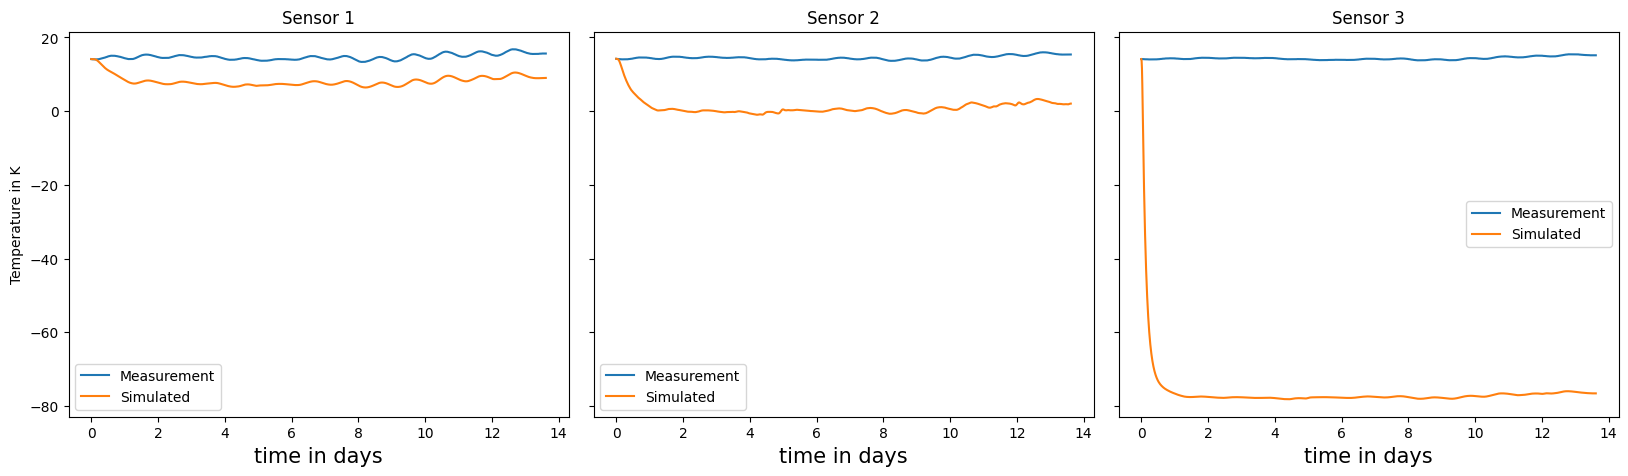

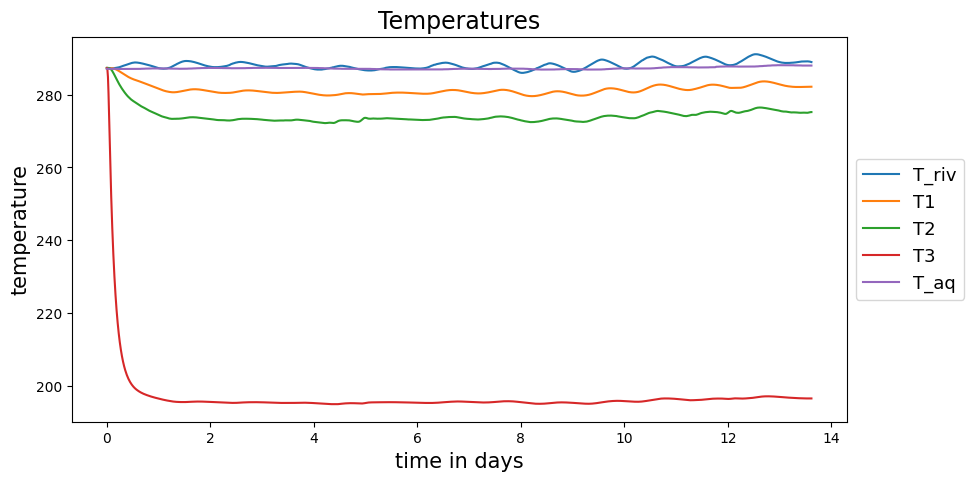

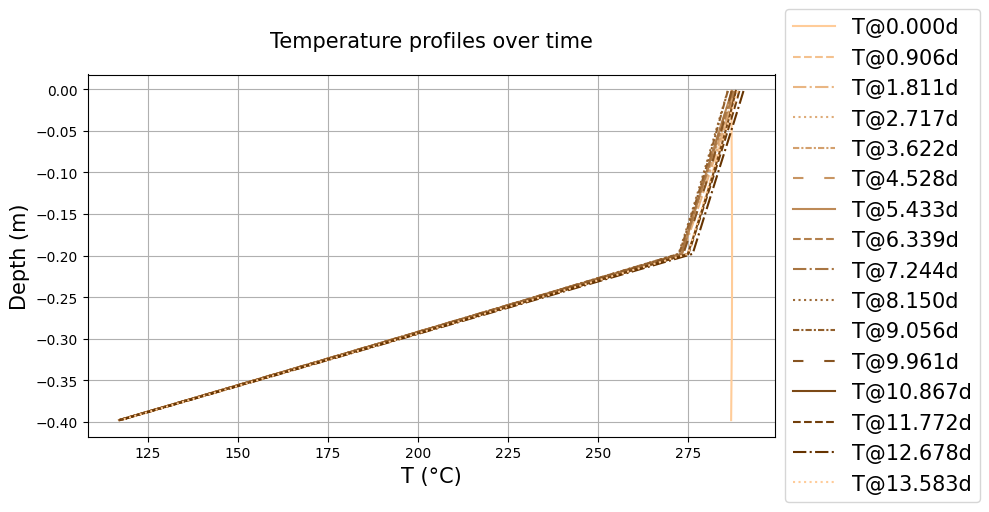

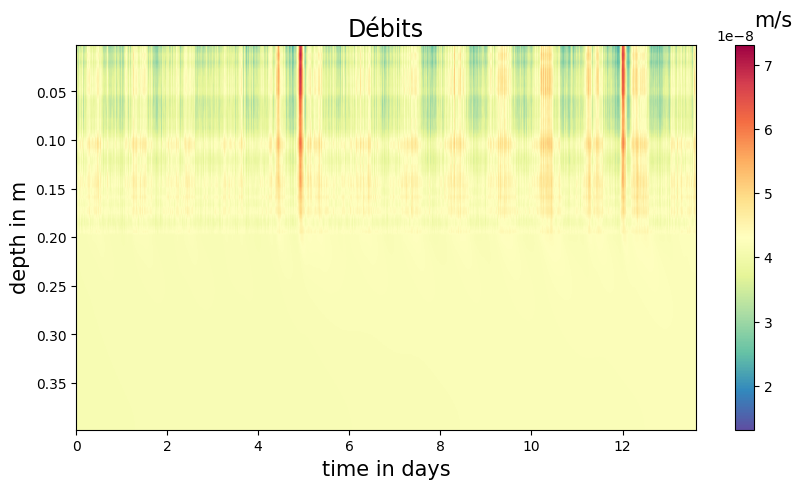

In [ ]:
col.compute_solve_transi(layers_list,verbose=False)

col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()
col.plot_temperature_at_sensors()
nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))
flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

## 3.2 Inférence bayésienne

L'inférence bayésienne va nous permettre d'estimer une distribution a posteriori pour chaque paramètre.

### 3.2.1. MCMC sans estimation de l'erreur

On peut lancer une MCMC en gardant $\sigma^2$ constant. On définit des distributions a priori pour chaque couche :

In [ ]:
priors_couche_1 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1,10), .1)
}

priors_couche_2 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1,10), .1)
}

all_priors = [
    ['Couche 1', Zinterface, priors_couche_1],
    ['Couche 2', Zbottom, priors_couche_2],
]

col.compute_mcmc(
    nb_iter = 700,
    all_priors = all_priors,
    sigma2=1.0,
    verbose=False
)

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1, 10), 0.1)}
{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1, 10), 0.1)}
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1 et 10]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1 et 10]
Number of cells : 100
Number of iterations : 700
Number of c

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:39: RuntimeWarning: overflow encountered in exp
  mu = A * np.exp(B * 1.0 / T + C * T + D * (T**2))


Initialisation - Utilisation de la mémoire (en Mo) : 296.337408
--- Begin Burn in phase ---


Burn in phase:   3%|▎         | 21/700 [00:08<04:32,  2.49it/s]/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:39: RuntimeWarning: overflow encountered in square
  mu = A * np.exp(B * 1.0 / T + C * T + D * (T**2))
Burn in phase:  79%|███████▉  | 553/700 [03:43<00:59,  2.48it/s]/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:39: RuntimeWarning: invalid value encountered in add
  mu = A * np.exp(B * 1.0 / T + C * T + D * (T**2))
Burn in phase: 100%|██████████| 700/700 [04:42<00:00,  2.47it/s]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 131.743744
DREAM MCMC Computation:   0%|          | 1/700 [00:00<09:35,  1.21it/s]

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:39: RuntimeWarning: overflow encountered in exp
  mu = A * np.exp(B * 1.0 / T + C * T + D * (T**2))


DREAM MCMC Computation:   1%|          | 5/700 [00:02<06:27,  1.79it/s]

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/linear_system.py:39: RuntimeWarning: overflow encountered in square
  mu = A * np.exp(B * 1.0 / T + C * T + D * (T**2))


DREAM MCMC Computation: 100%|██████████| 700/700 [06:14<00:00,  1.87it/s]
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 137.78944
Quantiles computed


#### Recupération et affichage des distributions

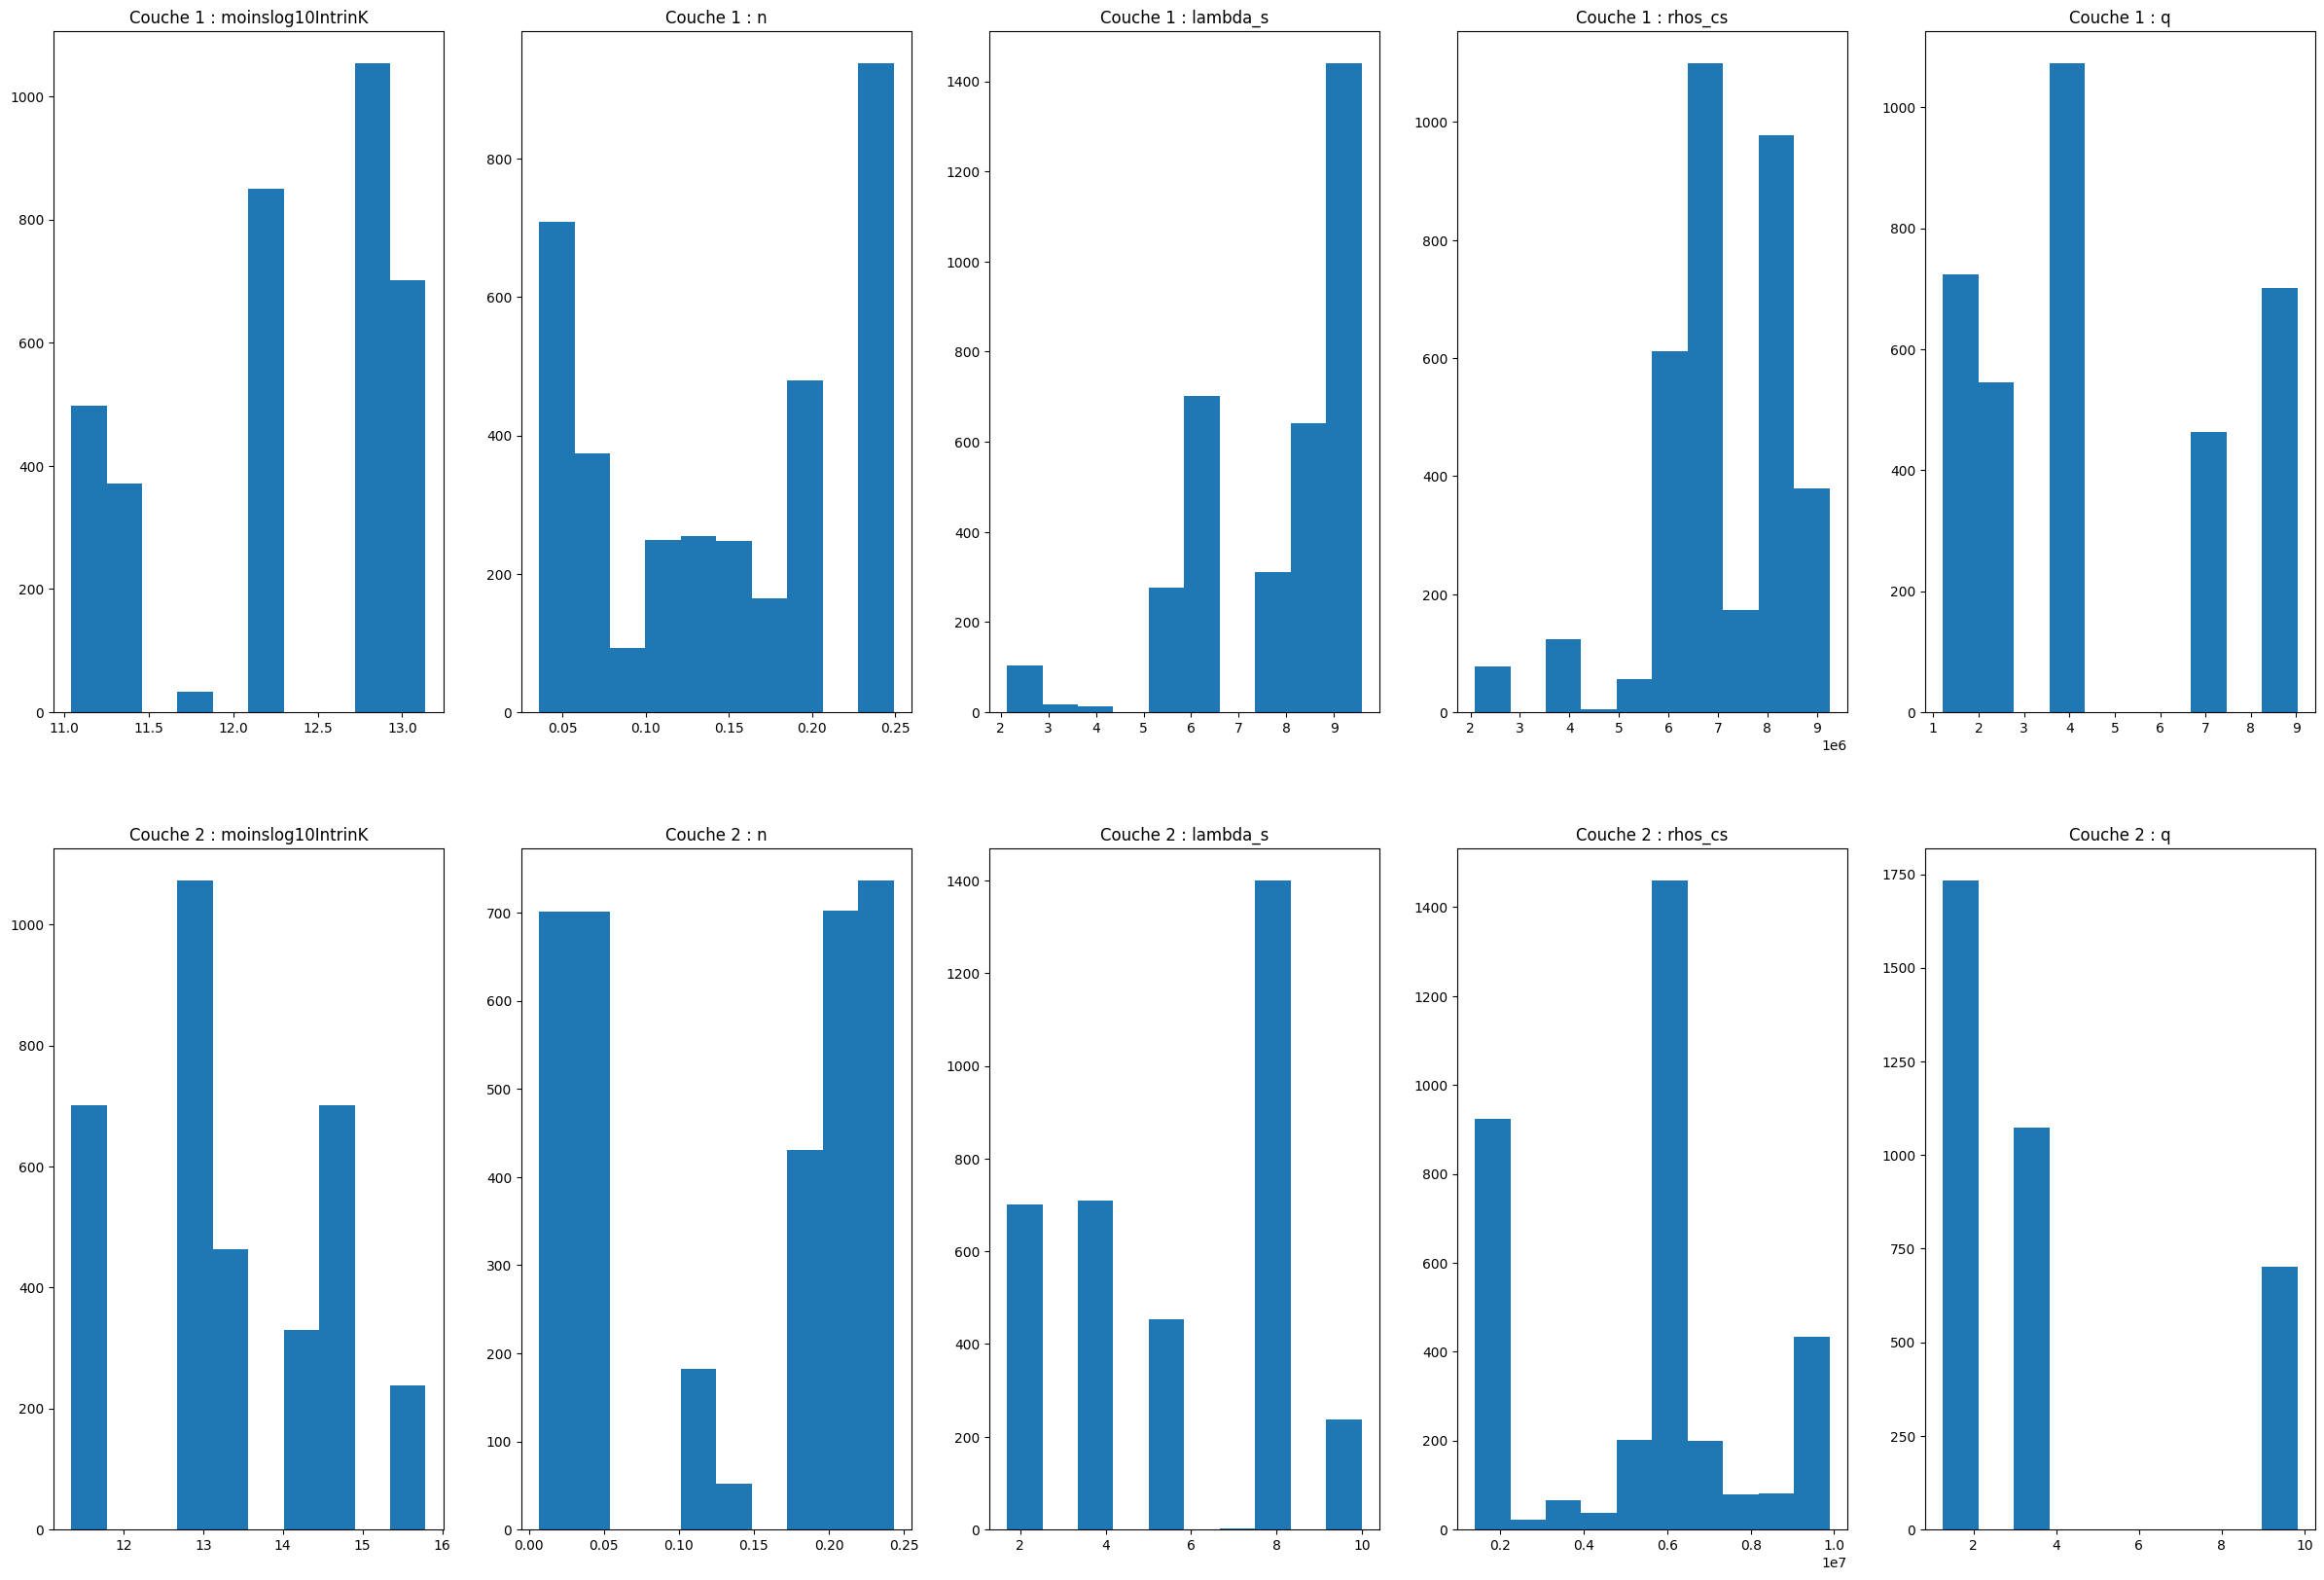

In [ ]:
col.plot_all_param_pdf()

RMSE at sensor 0 : inf
RMSE at sensor 1 : inf
RMSE at sensor 2 : inf
Total RMSE : inf


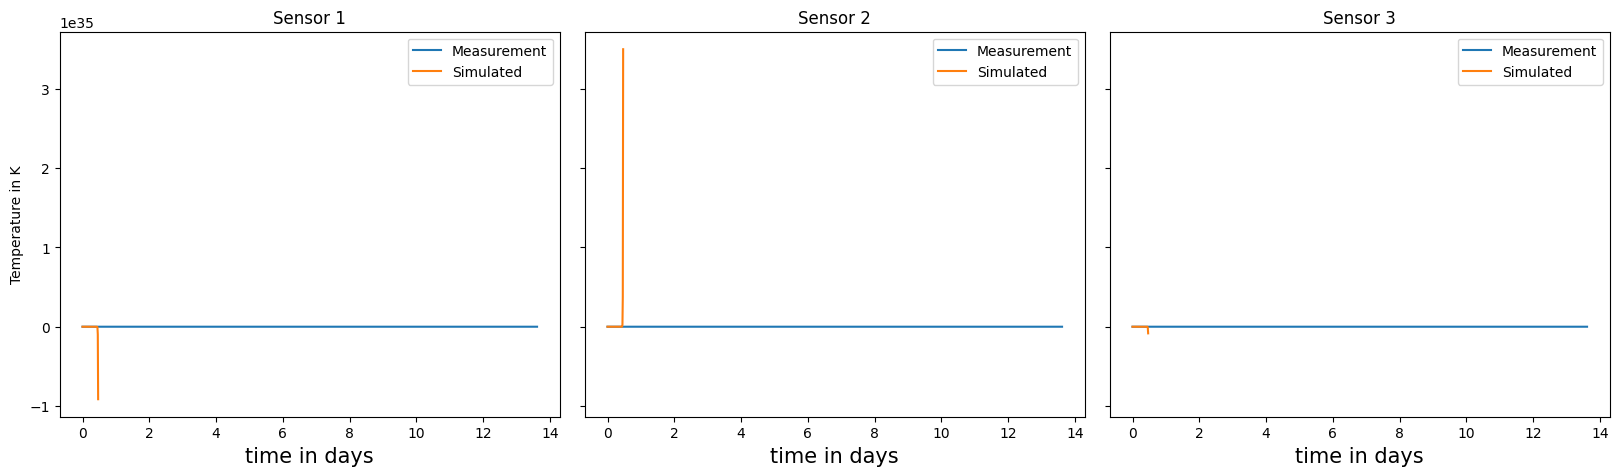

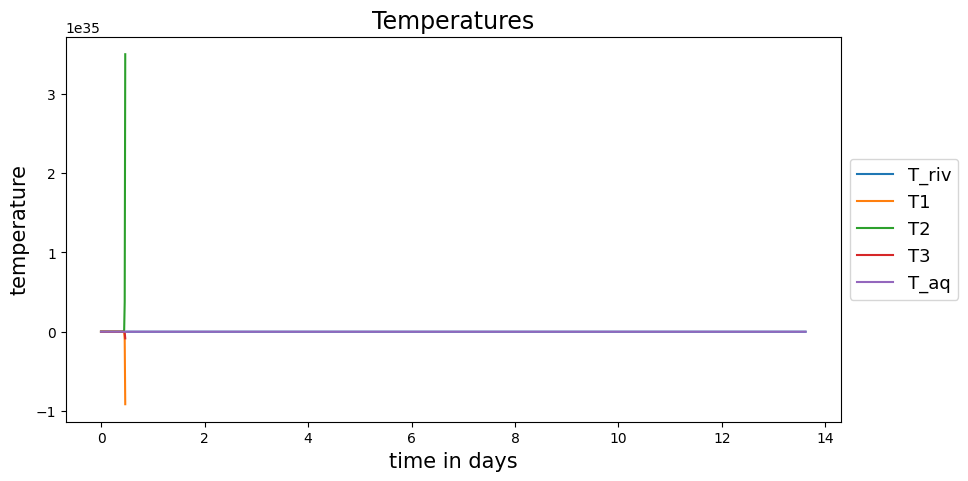

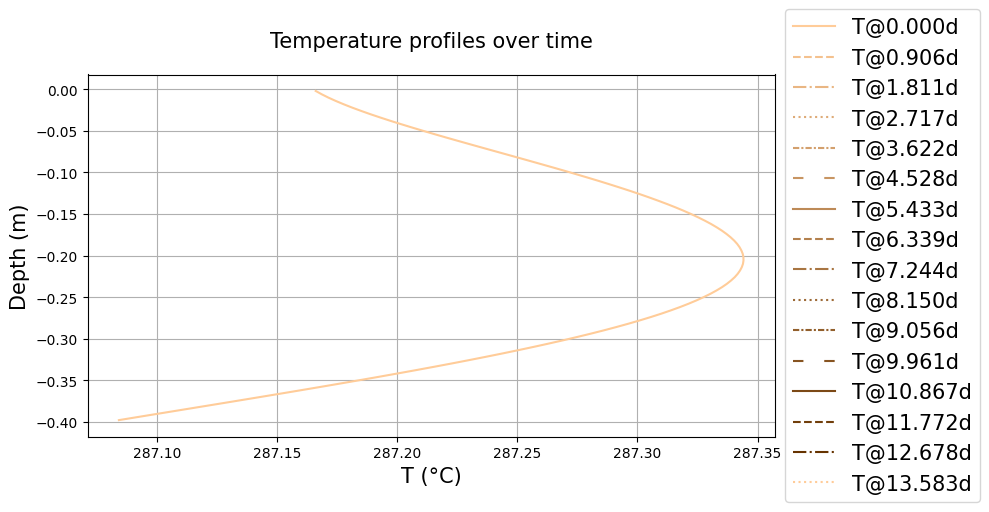

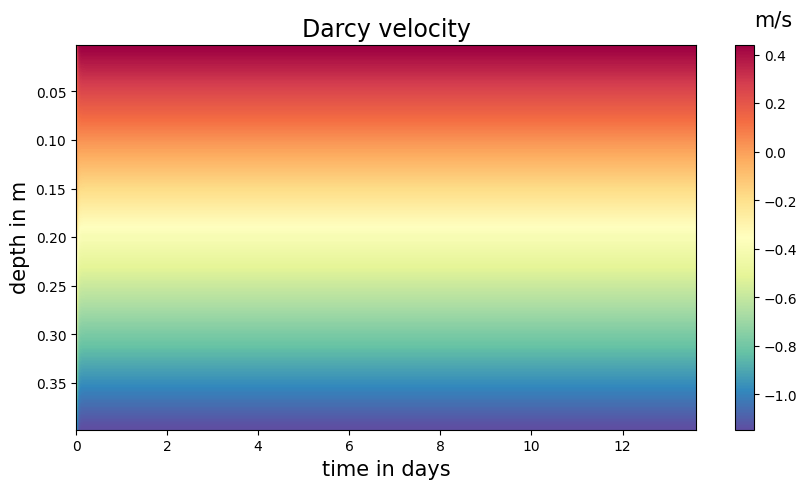

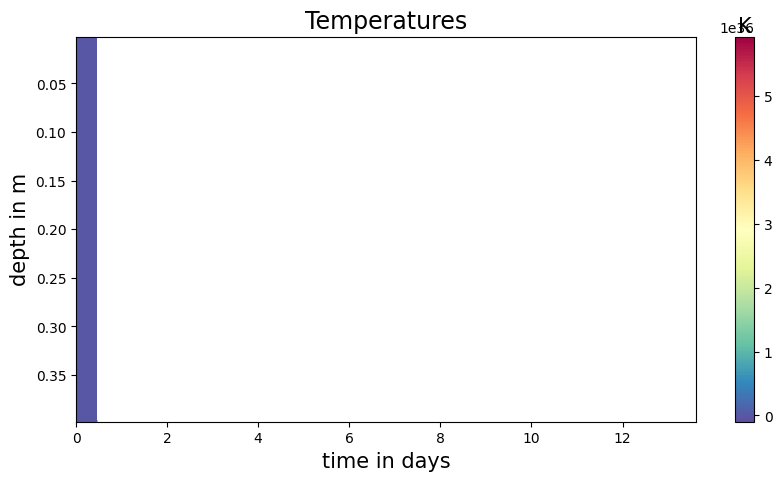

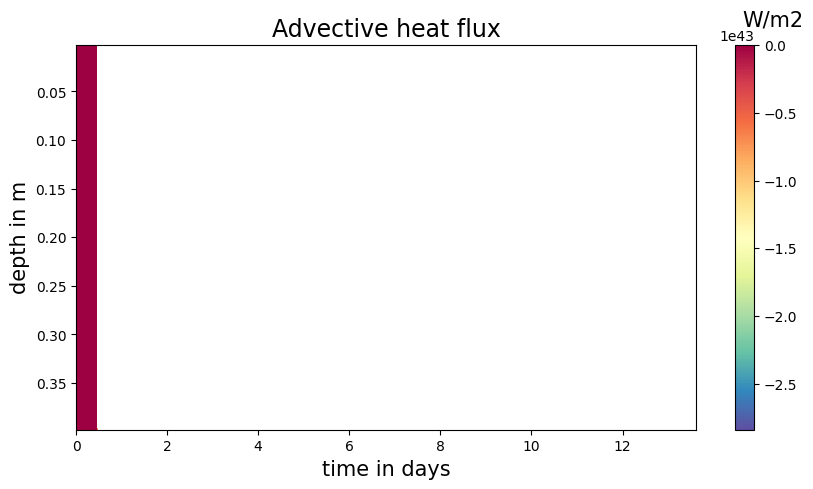

/Users/omblinebrunet/Info/Molonari/MOLONARI1D/pyheatmy/pyheatmy/core.py:804: RuntimeWarning: invalid value encountered in subtract
  nablaT = np.zeros((nb_cells, len(self._times)), np.float32)


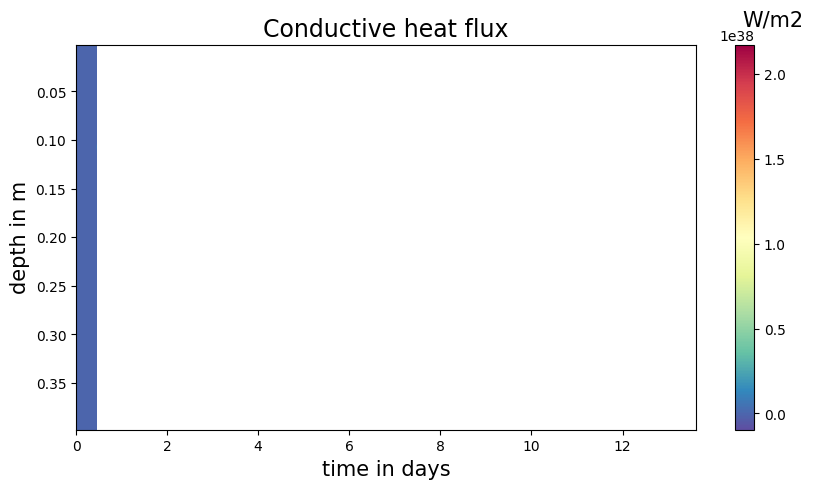

Plotting Température in column. time series have nrecords =  1309


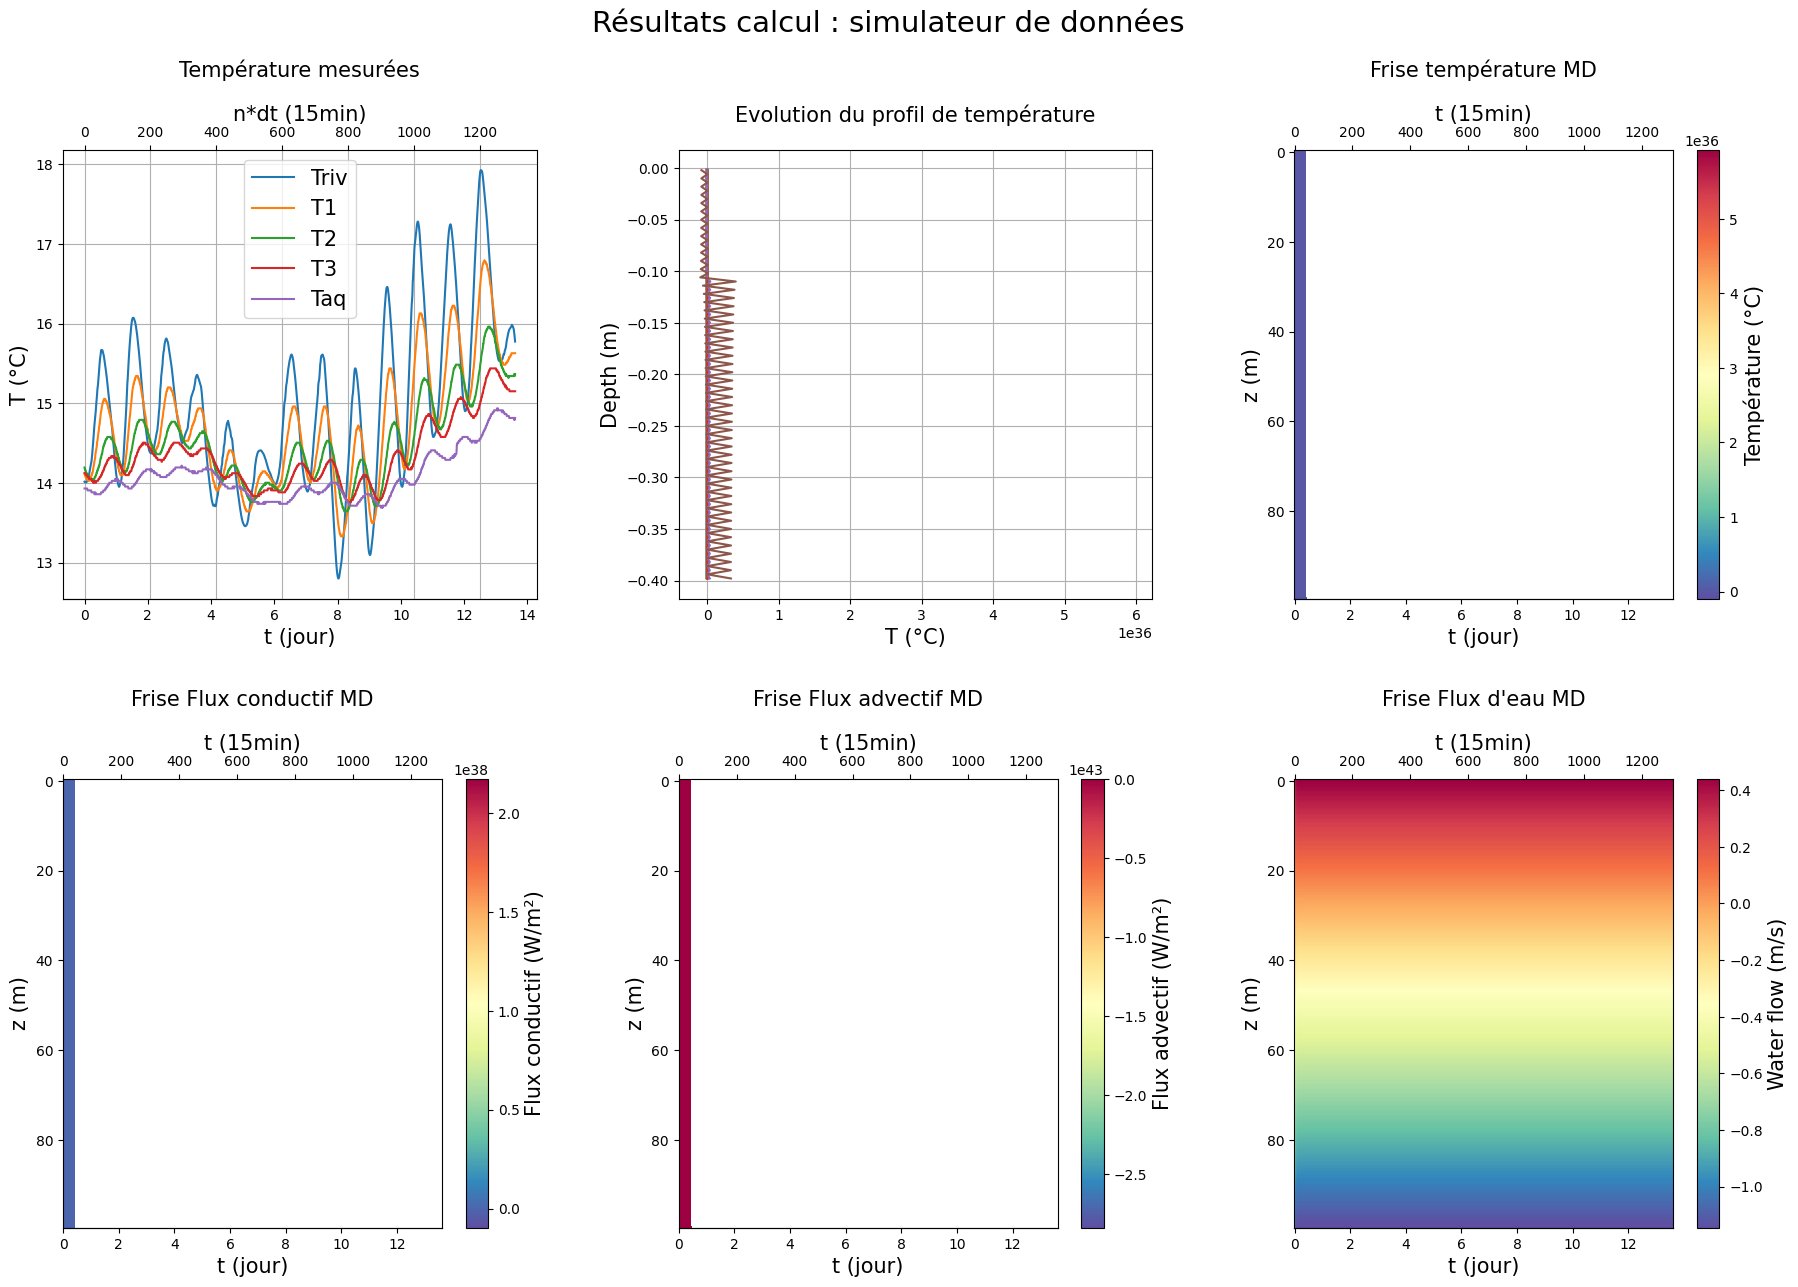

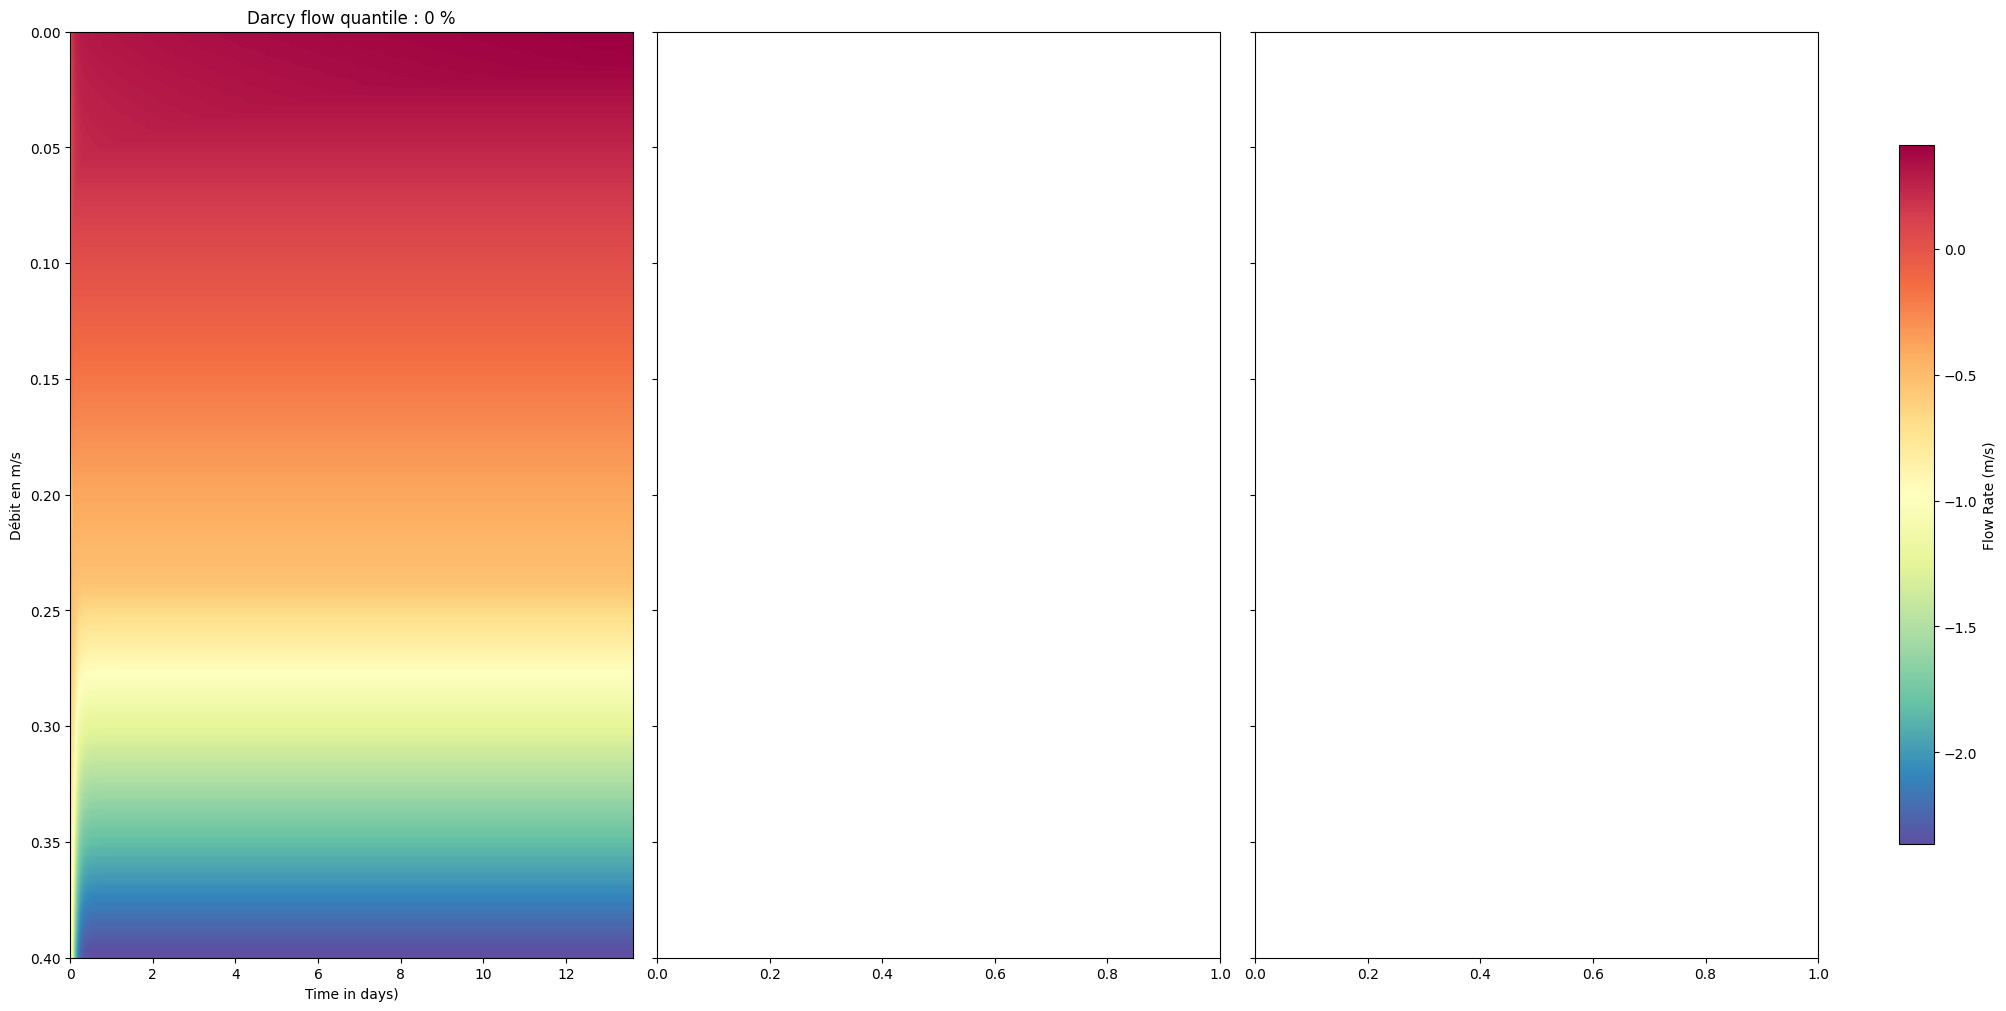

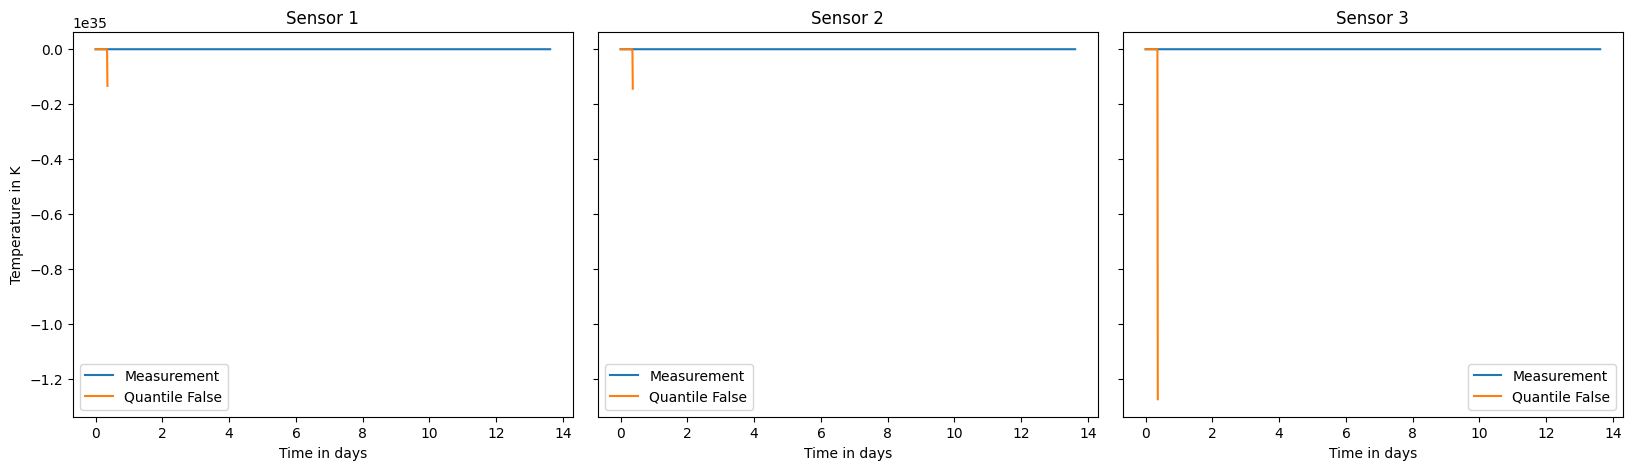

In [ ]:
bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers,verbose=False)
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

#### Options : Récupération d'autres paramètres
Voici les un exemple de paramètres qui, normalement, sont bons :

In [ ]:
otherGoodLayers = layersListCreator([("Couche 1", 0.20, 7.915378861204348, 0.1310721719612464, 5.602951622531522, 4758163.582292321, 1),
("Couche 2", 0.40, 6.574103692603533, 0.029547616319484868, 3.944439207155854, 4931216.13398901, 1)])

#### 3.2.3 MCMC avec estimation de l'erreur

Pour lancer une MCMC avec estimation de la distribution de $\sigma^2$, il suffit d'ajouter une distribution a priori sur ce paramètre. On utilise pour cela la classe ``Prior``, qui est initialisée avec :
- un tuple pour l'intervalle dans lequel le paramètre varie
- un écart type pour la marche aléatoire
- une densité

In [ ]:
sigma_prior = Prior((0.1, np.inf), 0.1, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 700,
    all_priors = all_priors,
    sigma2_temp_prior = sigma_prior,
    verbose=False
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers,verbose=False)
col.plot_all_param_pdf()
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1, 10), 0.1)}
{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1, 10), 0.1)}
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1 et 10]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1 et 10]
Number of cells : 100
Number of iterations : 700
Number of c

Burn in phase:  18%|█▊        | 125/700 [00:51<03:56,  2.44it/s]


KeyboardInterrupt: 